<a href="https://colab.research.google.com/github/justme088/lab-termodinamica/blob/main/Laboratorio2_Termodinamica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio 2 de Termodinámica - COMPARACIÓN CRUZADA DE CALORÍMETROS**

## Profesora: Mayubell Alvarado-Valdes

Grupo: Jostin Vargas, Alejandro Philips, Roxana Figueroa, Aidan García, Dionisio Conde, Keysi Bonilla

# A. COMPARACIÓN DE CALORÍMETROS

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy import stats

In [138]:
def recortar_dataframe(df1, df2):
    # Determinar la longitud mínima entre df1 y df2
    longitud_minima = min(len(df1), len(df2))

    # Recortar df1 para que tenga la misma longitud que df2
    df1_recortado = df1.head(longitud_minima)

    return df1_recortado

def dataframe_mas_corto(array_dataframes):
    longitud_mas_corta = float('inf')  # Inicializar con un valor grande
    dataframe_mas_corto = None

    # Iterar sobre cada DataFrame en el array
    for df in array_dataframes:
        longitud_actual = len(df)
        if longitud_actual < longitud_mas_corta:
            longitud_mas_corta = longitud_actual
            dataframe_mas_corto = df

    return dataframe_mas_corto

def interpolacion_polinomica(x,y,n=3):
  coeffs = np.polyfit(x, y, n)
  poly = np.poly1d(coeffs)
  x_new = np.linspace(x.min(), x.max(), 100)
  return [x_new, poly(x_new)]

def calcular_R2(y_observado, y_ajustado):
    ss_res = np.sum((y_observado - y_ajustado) ** 2)
    ss_tot = np.sum((y_observado - np.mean(y_observado)) ** 2)
    return 1 - (ss_res / ss_tot)

# **Sección 1. Mezcla de agua y hielo.**

### **Agua destilada , comparación de valores obtenidos entre ambas termocuplas**

In [139]:
# Se analizará primero el agua destilada, se medirá la temperatura de esta y las diferencias que hubieron en cada repetición de esta medición.

f1 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep1/temp1_agua_destilada.csv'
f2 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep2/temp1_agua_destilada.csv'
f3 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep3/temp1_agua_destilada.csv'

d1 = pd.read_csv(f1)
d2 = pd.read_csv(f2)
d3 = pd.read_csv(f3)

Diferencias promedios de la temperatura medida del agua destilada (termocupla 1):
· repetición 1 con repetición 3: 0.14 ºC
· repetición 2 con repetición 1: 1.31 ºC
· repetición 2 con repetición 3: 1.45 ºC



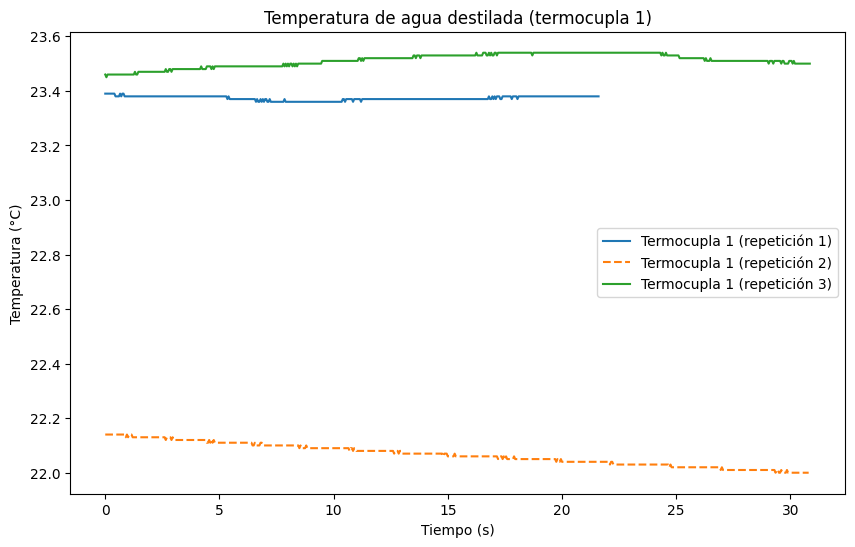

In [140]:
# Primero se iniciará con las mediciones realizadas con la termocupla 1.

# Se configura la graficación de los datos para una mejor visualización de los mismos.
plt.figure(figsize=(10, 6))
plt.plot(d1['Tiempo'], d1['Termocupla_1'], label='Termocupla 1 (repetición 1)')
plt.plot(d2['Tiempo'], d2['Termocupla_1'], label='Termocupla 1 (repetición 2)', linestyle='dashed')
plt.plot(d3['Tiempo'], d3['Termocupla_1'], label='Termocupla 1 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de agua destilada (termocupla 1)')
plt.legend()

# Es observado que entre cada repetición de la misma medición del agua destilada, hay cierta diferencia, en especial con la repetición 2.

# Ya que las mediciones siguen un patrón casi lineal al no haber tanto intercambio de calor con la muestra de agua destilada,
# se denota solo la diferencia existente en los valores de el eje "y".

# Una forma de denotar númericamente estas diferencias es realizando diferencias de los promedios de cada repetición.
print("Diferencias promedios de la temperatura medida del agua destilada (termocupla 1):")
dif_d1_d3 = round(abs(np.mean([d1['Termocupla_1']]) - np.mean([d3['Termocupla_1']])),2)
print('· repetición 1 con repetición 3: '+str(dif_d1_d3)+' ºC')

dif_d2_d1 = round(abs(np.mean([d2['Termocupla_1']]) - np.mean([d1['Termocupla_1']])),2)
dif_d2_d3 = round(abs(np.mean([d2['Termocupla_1']]) - np.mean([d3['Termocupla_1']])),2)
print('· repetición 2 con repetición 1: '+str(dif_d2_d1)+' ºC')
print('· repetición 2 con repetición 3: '+str(dif_d2_d3)+' ºC'+'\n')

plt.show()


Análisis de varianza (ANOVA) de la temperatura medida del agua destilada (termocupla 1)

Estadístico F: 453828.38315486786
Valor p: 0.0
Hay diferencias significativas entre al menos dos grupos.



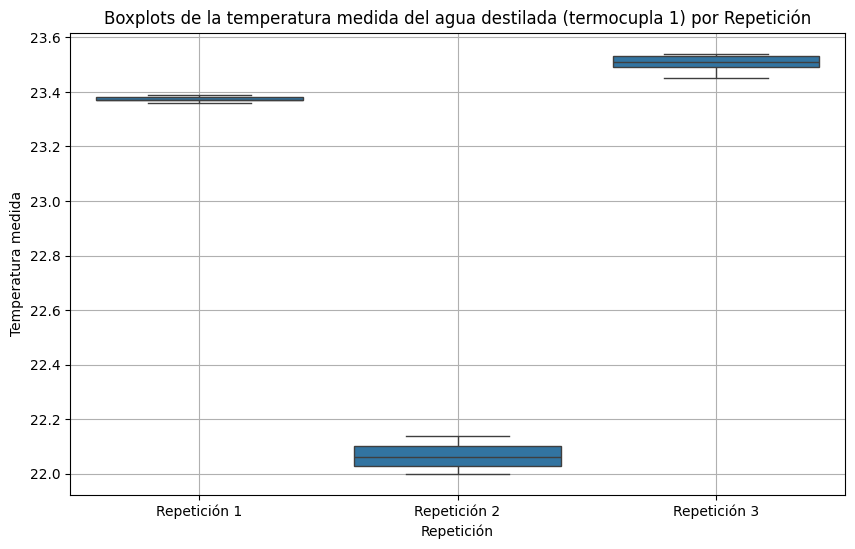

In [141]:
# Para realizar una interpretación estadística no solo a través de diferencias de promedios, se puede aplicar ANOVA.
# Este se debe a que el ANOVA (Análisis de Varianza) es una técnica estadística utilizada para comparar las medias de tres
# o más grupos y determinar si existen diferencias significativas entre ellos.

# Una forma de visualizar también eso junto a la varianza de los datos, es a travésde los boxplots por cómo representan las distribución de los datos
# a través de cuartiles, denotando también la media y denotando los valores que son atípicos.

df = pd.DataFrame({
    'Grupo': ['Repetición 1'] * len(d1['Termocupla_1']) + ['Repetición 2'] * len(d2['Termocupla_1']) + ['Repetición 3'] * len(d3['Termocupla_1']),
    'Termocupla_1': pd.concat([d1['Termocupla_1'], d2['Termocupla_1'], d3['Termocupla_1']])
})

# Graficar boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Grupo', y='Termocupla_1', data=df)
plt.title('Boxplots de la temperatura medida del agua destilada (termocupla 1) por Repetición')
plt.xlabel('Repetición')
plt.ylabel('Temperatura medida')
plt.grid(True)

# Aplicar ANOVA
statistic, p_value = f_oneway(d1['Termocupla_1'], d2['Termocupla_1'], d3['Termocupla_1'])

# Mostrar resultados
print('Análisis de varianza (ANOVA) de la temperatura medida del agua destilada (termocupla 1)\n')
print(f'Estadístico F: {statistic}')
print(f'Valor p: {p_value}')

# Interpretación del resultado
alpha = 0.05
if p_value < alpha:
    print('Hay diferencias significativas entre al menos dos grupos.')
else:
    print('No hay evidencia suficiente para afirmar diferencias significativas entre los grupos.')
print()
plt.show()

In [142]:
# El estadístico F es un valor de gran magnitud, significnado que existe una varianza altamente significativa entre los datos. Algo que se aprecia con el gráfico
# de boxplots.
# La diferencia de temperaturas entre cada repetición puede deberse al la diferencia de tiempo a la hora de haber realizado cada medición, además de haber medido la
# temperatura de otros objetos de estudio de por medio.

Diferencias promedios de la temperatura medida del agua destilada (termocupla 2):
· repetición 1 con repetición 3: 0.61 ºC
· repetición 2 con repetición 1: 2.11 ºC
· repetición 2 con repetición 3: 1.49 ºC



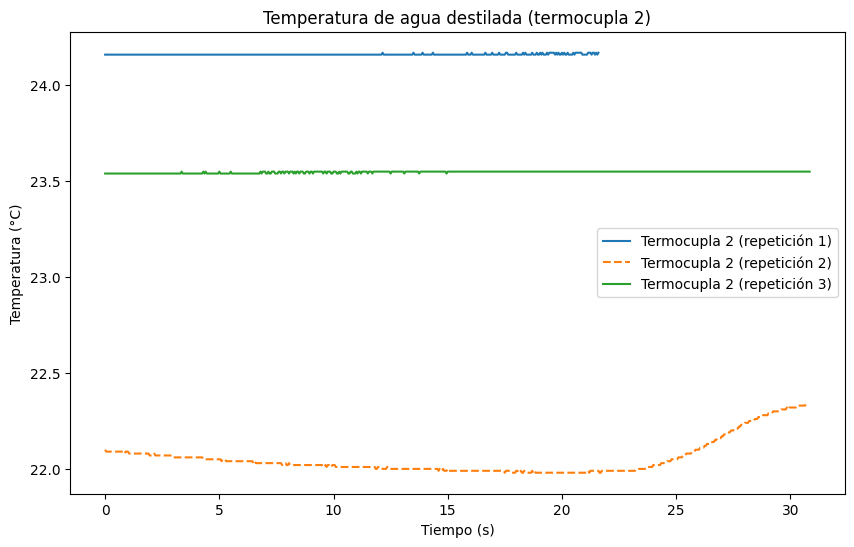

In [143]:
# Luego de analizar los datos con la termocupla 1, ahora se verán las mediciones tomadas a través de la termocupla 2
# y con las gráficos y estadísticias ver la diferencia entre cada conjunto de mediciones.

# Se configuran los datos de las temperatura medidas del agua destilada en cada repetición usando la termocupla 2.
plt.figure(figsize=(10, 6))
plt.plot(d1['Tiempo'], d1['Termocupla_2'], label='Termocupla 2 (repetición 1)')
plt.plot(d2['Tiempo'], d2['Termocupla_2'], label='Termocupla 2 (repetición 2)', linestyle='dashed')
plt.plot(d3['Tiempo'], d3['Termocupla_2'], label='Termocupla 2 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de agua destilada (termocupla 2)')
plt.legend()

# Ya que las mediciones siguen una tendencia lineal, se puede tomar la diferencia de promedios de cada serie de mediciones de
# temperatura para ver la lejanía en el eje "y" entre cada una.
print("Diferencias promedios de la temperatura medida del agua destilada (termocupla 2):")
dif_d1_d3 = round(abs(np.mean([d1['Termocupla_2']]) - np.mean([d3['Termocupla_2']])),2)
print('· repetición 1 con repetición 3: '+str(dif_d1_d3)+' ºC')

dif_d2_d1 = round(abs(np.mean([d2['Termocupla_2']]) - np.mean([d1['Termocupla_2']])),2)
dif_d2_d3 = round(abs(np.mean([d2['Termocupla_2']]) - np.mean([d3['Termocupla_2']])),2)
print('· repetición 2 con repetición 1: '+str(dif_d2_d1)+' ºC')
print('· repetición 2 con repetición 3: '+str(dif_d2_d3)+' ºC'+'\n')

plt.show()

Análisis de varianza (ANOVA)

Estadístico F: 206652.5355699398
Valor p: 0.0
Hay diferencias significativas entre al menos dos grupos.



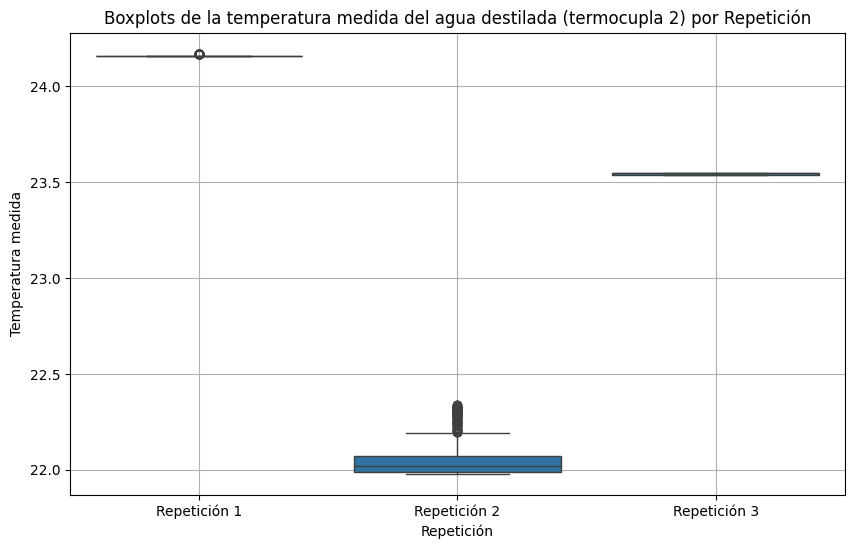

In [144]:
# Se aplicará ANOVA para interpretar numéricamente la varianza existente entre cada medición hecha con la termocupla 2 al agua destilada.
# Además se usarán boxplots para demostrar gráficamente características que conllevan a la varianza que hay entre cada repetición.

df = pd.DataFrame({
    'Grupo': ['Repetición 1'] * len(d1['Termocupla_2']) + ['Repetición 2'] * len(d2['Termocupla_2']) + ['Repetición 3'] * len(d3['Termocupla_2']),
    'Termocupla_2': pd.concat([d1['Termocupla_2'], d2['Termocupla_2'], d3['Termocupla_2']])
})

# Graficar boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Grupo', y='Termocupla_2', data=df)
plt.title('Boxplots de la temperatura medida del agua destilada (termocupla 2) por Repetición')
plt.xlabel('Repetición')
plt.ylabel('Temperatura medida')
plt.grid(True)


# Aplicar ANOVA
statistic, p_value = f_oneway(d1['Termocupla_2'], d2['Termocupla_2'], d3['Termocupla_2'])

# Mostrar resultados
print('Análisis de varianza (ANOVA)\n')
print(f'Estadístico F: {statistic}')
print(f'Valor p: {p_value}')

# Interpretación del resultado
alpha = 0.05
if p_value < alpha:
    print('Hay diferencias significativas entre al menos dos grupos.')
else:
    print('No hay evidencia suficiente para afirmar diferencias significativas entre los grupos.')
print()
plt.show()

In [145]:
# El estadístico F también fue de gran magnitud para las mediciones con la termocupla 2, significando gran varianza, aspécto que se puede observar a través del gráfico con boxplots.
# Donde la distribución y rango de datos entre cada repitición es significativamente distinta, además de que la repetición 1 y 2 cuentan con valores atípicos.

### **Hielo, comparación de valores obtenidos entre ambas termocuplas dentro de cada calorímetro correspondiente a estas**

In [146]:
# Se medirá el hielo a usar en la mezcla posteriormente. Se hizo dentro un calorímetro para obtener mejores mediciones al haber menor transferencia de calor por
# estar en un sistema cerrado decente.

# Al calorímetro de laboratorio le corresponde la termocupla 1.
# Termocupla 1 - Calorímetro de laboratorio
f4 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep1/temp2_hielo_calorimetro_serio_termocupla1.csv'
f5 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep2/temp2_hielo_calorimetro_serio_termocupla1.csv'
f6 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep3/temp2_hielo_calorimetro_serio_termocupla1.csv'
d4 = pd.read_csv(f4)
d5 = pd.read_csv(f5)
d6 = pd.read_csv(f6)

# Al calorímetro casero le corresponde la termocupla 2.
# Termocupla 2 - Calorímetro casero
f7 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep1/temp3_hielo_calorimetro_casero_termocupla2.csv'
f8 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep2/temp3_hielo_calorimetro_casero_termocupla2.csv'
f9 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep3/temp3_hielo_calorimetro_casero_termocupla2.csv'
d7 = pd.read_csv(f7)
d8 = pd.read_csv(f8)
d9 = pd.read_csv(f9)

### Calorímetro de laboratorio, termocupla 1, medición de hielo

Diferencias promedios de la temperatura medida del hielo en calorímetro de laboratorio (termocupla 1):
· repetición 1 con repetición 2: 0.17 ºC
· repetición 1 con repetición 3: 5.29 ºC
· repetición 2 con repetición 3: 5.46 ºC



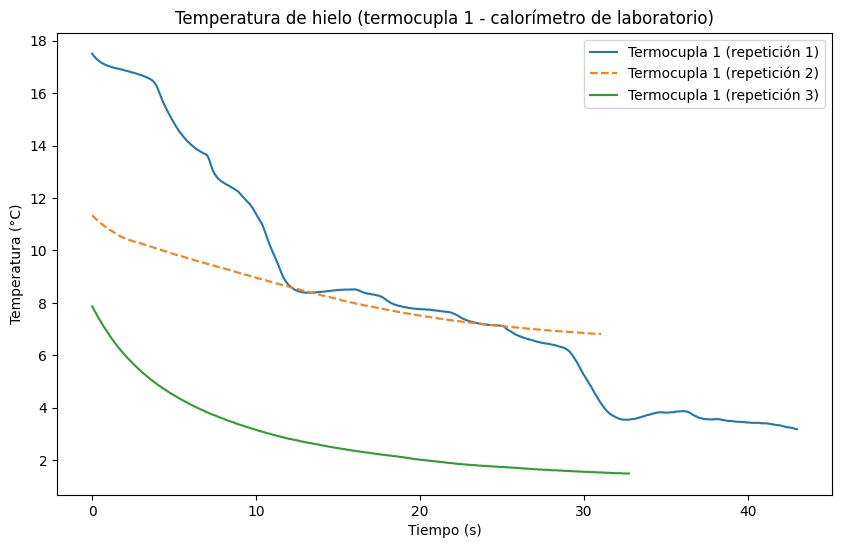

In [147]:
# Calorímetro de laboratorio - termocupla 1

# Se ordenan los datos de cada medición hecha por la termocupla 1 dentro del calorímetro de laboratorio
# para ser graficadas y ver la tendencia de cada una.
plt.figure(figsize=(10, 6))
plt.plot(d4['Tiempo'], d4['Termocupla_1'], label='Termocupla 1 (repetición 1)')
plt.plot(d5['Tiempo'], d5['Termocupla_1'], label='Termocupla 1 (repetición 2)', linestyle='dashed')
plt.plot(d6['Tiempo'], d6['Termocupla_1'], label='Termocupla 1 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de hielo (termocupla 1 - calorímetro de laboratorio)')
plt.legend()

# Ya que tienen una tendencia lineal, se les aplica diferencia de promedios de cada medición realizada para entender
# la diferencia promedio existencia en el eje "y" entre cada repetición realizada.
print("Diferencias promedios de la temperatura medida del hielo en calorímetro de laboratorio (termocupla 1):")
dif_d4_d5 = round(abs(np.mean([d4['Termocupla_1']]) - np.mean([d5['Termocupla_1']])),2)
dif_d4_d6 = round(abs(np.mean([d4['Termocupla_1']]) - np.mean([d6['Termocupla_1']])),2)
print('· repetición 1 con repetición 2: '+str(dif_d4_d5)+' ºC')
print('· repetición 1 con repetición 3: '+str(dif_d4_d6)+' ºC')

dif_d5_d6 = round(abs(np.mean([d5['Termocupla_1']]) - np.mean([d6['Termocupla_1']])),2)
print('· repetición 2 con repetición 3: '+str(dif_d5_d6)+' ºC'+'\n')

plt.show()

In [148]:
# A pesar de que en las repeticiones 2 y 3, la temperatura siga una tendencia curvada donde la diferencia entre estos conjuntos es en el eje "y", en la
# repetición 1 la tendencia es muy irregular pero se puede ver que sigue una tendencia curvada también, esto puede deberse a alguna irregularidad a la hora
# de haber hecho la medición. Puede haber sido contacto directo con las paredes del calorímetro al estarse sosteniendo para evitar el contacto con las paredes
# del mismo.

Tasa de enfriamiento promedio del Calorímetro 1: -0.33 °C/s
Tasa de enfriamiento promedio del Calorímetro 2: -0.15 °C/s
Tasa de enfriamiento promedio del Calorímetro 3: -0.19 °C/s



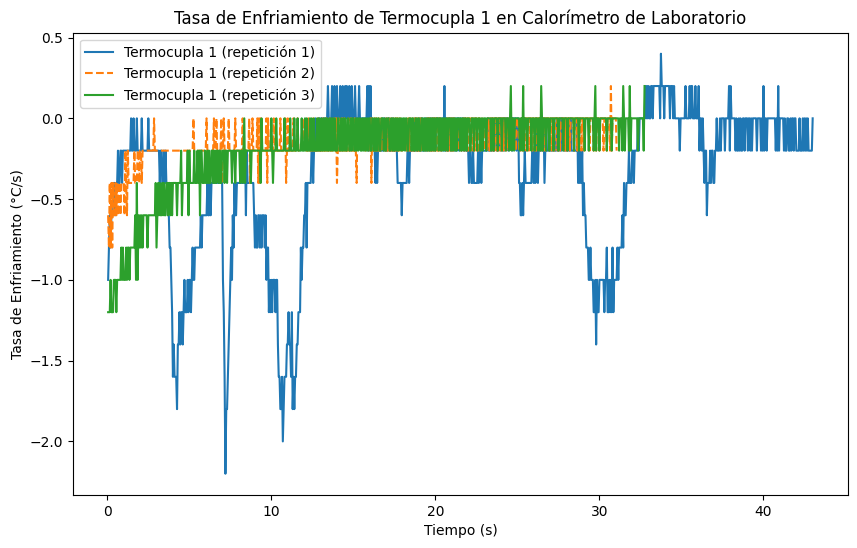

In [149]:
# Calorímetro de laboratorio - termocupla 1

# Para entender mejor la utilidad del calorímetro en cuanto retención de calor, es la tasa de enfriamiento a lo largo del tiempo.
# Qué tanto pierde calor en determinado momento y cómo se mantiene ello.

# A través del cálculo de la gradiente en cada serie de datos, se obtiene la tasa de enfriamiento.
d4['tasa_enfriamiento_1'] = d4['Termocupla_1'].diff()/d4['Tiempo'].diff()
d5['tasa_enfriamiento_2'] = d5['Termocupla_1'].diff()/d5['Tiempo'].diff()
d6['tasa_enfriamiento_3'] = d6['Termocupla_1'].diff()/d6['Tiempo'].diff()

# Se grafica la tasa de cambio obtenida.
plt.figure(figsize=(10, 6))
plt.plot(d4['Tiempo'], d4['tasa_enfriamiento_1'], label='Termocupla 1 (repetición 1)')
plt.plot(d5['Tiempo'], d5['tasa_enfriamiento_2'], label='Termocupla 1 (repetición 2)', linestyle='dashed')
plt.plot(d6['Tiempo'], d6['tasa_enfriamiento_3'], label='Termocupla 1 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento de Termocupla 1 en Calorímetro de Laboratorio')
plt.legend()

# Tasa de cambio promedio
tasa_promedio_1 = round(d4['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d5['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d6['tasa_enfriamiento_3'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro 1: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro 2: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro 3: {tasa_promedio_3} °C/s'+'\n')

plt.show()

In [150]:
# A pesar de obtener información de la tasa de enfriamiento gracias al promedio de cada gradiente realizada en las distintas repeticiones hechas con la termocupla 1,
# gráficamente no se puede comprender bien la tendencia de cada una por la forma en que se distribuyen los datos, habiendo muchos picos y valles.

Tasa de enfriamiento promedio del Calorímetro 1: -0.33 °C/s
Tasa de enfriamiento promedio del Calorímetro 2: -0.15 °C/s
Tasa de enfriamiento promedio del Calorímetro 3: -0.19 °C/s

Tasa de enfriamiento promedio (suavizada) del Calorímetro de laboratorio [repetición 1]: -0.33 °C/s
Tasa de enfriamiento promedio (suavizada) del Calorímetro de laboratorio [repetición 2]: -0.15 °C/s
Tasa de enfriamiento promedio (suavizada) del Calorímetro de laboratorio [repetición 3]: -0.19 °C/s



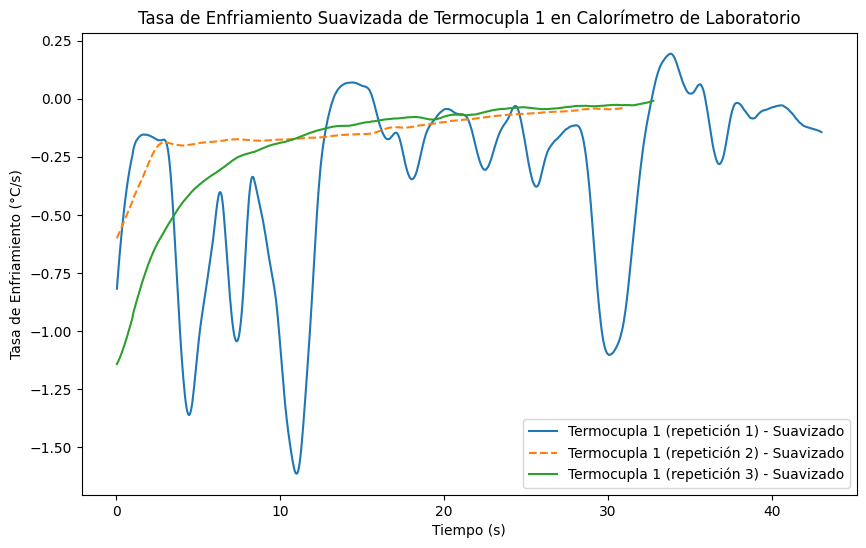

In [151]:
# Esto se puede solucionar con un suavizado de los vertices. Se aplica el filtrado uniforme 1-D, que es aplicar un filtro de media móvil uniforme a una serie de datos unidimensional,
# este filtro calcula la media de los valores adyacentes en la serie de datos utilizando una ventana de tamaño especificado, donde la ventana es la cantidad de puntos se promedian.
# Y se aplica adicionalmente el filtro de Savitzky-Gola, que suaviza más los datos gracias a que ajusta localmente una función polinomial a los datos en cada punto de la señal y esto
# se ve afectado también por el orden especificado del polinomio.

# Calcular la tasa de enfriamiento.
d4['tasa_enfriamiento_1'] = d4['Termocupla_1'].diff() / d4['Tiempo'].diff()
d5['tasa_enfriamiento_2'] = d5['Termocupla_1'].diff() / d5['Tiempo'].diff()
d6['tasa_enfriamiento_3'] = d6['Termocupla_1'].diff() / d6['Tiempo'].diff()

d4.dropna(subset=['tasa_enfriamiento_1'], inplace=True)
d5.dropna(subset=['tasa_enfriamiento_2'], inplace=True)
d6.dropna(subset=['tasa_enfriamiento_3'], inplace=True)

# Suavizar los datos usando una media móvil

window_size = 40  # Ajusta este valor según sea necesario
poly_order = 3    # Orden del polinomio

d4['tasa_enfriamiento_1_suavizada'] = savgol_filter(uniform_filter1d(d4['tasa_enfriamiento_1'], size=10), window_size, poly_order)
d5['tasa_enfriamiento_2_suavizada'] = savgol_filter(uniform_filter1d(d5['tasa_enfriamiento_2'], size=20), window_size, poly_order)
d6['tasa_enfriamiento_3_suavizada'] = savgol_filter(uniform_filter1d(d6['tasa_enfriamiento_3'], size=20), window_size, poly_order)

# Graficar los datos suavizados
plt.figure(figsize=(10, 6))
plt.plot(d4['Tiempo'], d4['tasa_enfriamiento_1_suavizada'], label='Termocupla 1 (repetición 1) - Suavizado')
plt.plot(d5['Tiempo'], d5['tasa_enfriamiento_2_suavizada'], label='Termocupla 1 (repetición 2) - Suavizado', linestyle='dashed')
plt.plot(d6['Tiempo'], d6['tasa_enfriamiento_3_suavizada'], label='Termocupla 1 (repetición 3) - Suavizado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento Suavizada de Termocupla 1 en Calorímetro de Laboratorio')
plt.legend()

# Se comparan ahora las tasas de enfriamiento promedio entre los datos sin suavizar y los suavizados, demostrando que se mantiene el cambio y tendencia existente
# dentro de cada conjunto luego de haber hecho los dos filtrados.

tasa_promedio_1 = round(d4['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d5['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d6['tasa_enfriamiento_3'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro 1: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro 2: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro 3: {tasa_promedio_3} °C/s'+'\n')

tasa_promedio_1s = round(d4['tasa_enfriamiento_1_suavizada'].mean(),2)
tasa_promedio_2s = round(d5['tasa_enfriamiento_2_suavizada'].mean(),2)
tasa_promedio_3s = round(d6['tasa_enfriamiento_3_suavizada'].mean(),2)

print(f'Tasa de enfriamiento promedio (suavizada) del Calorímetro de laboratorio [repetición 1]: {tasa_promedio_1s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizada) del Calorímetro de laboratorio [repetición 2]: {tasa_promedio_2s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizada) del Calorímetro de laboratorio [repetición 3]: {tasa_promedio_3s} °C/s'+'\n')

plt.show()


In [152]:
# Se puede ver que los valores de tasa de enfriamiento promedio suavizados y no suavizados siguen siendo altemente cercanos, que en dos cifras decimales, dicha diferencia es nula.
# Gracias al suavizado se aprecia mejor la pérdida de calor que ocurrió en cada medición, donde una tasa de enfriamiento negativa significa adición de calor y una positiva pérdida de calor.
# Sin embargo, mientras que la tasa de enfriamiento para las repeticiones 2 y 3 son regulares, existe una alta irregularidad en la gradiente calculada para la repetición 1, donde esta
# situación se debe a que en primer lugar, la medición de la repetición 1 es irregular entre sus datos a pesar de seguir una trayectoria curva.

Diferencias promedios de la temperatura medida del hielo en calorímetro de laboratorio (termocupla 1):
· repetición 1 [interpolación polinómica] con repetición 2: 0.16 ºC
· repetición 1 [interpolación polinómica] con repetición 3: 5.31 ºC
· repetición 2 con repetición 3: 5.46 ºC

· repetición 1 con repetición 2: 0.18 ºC
· repetición 1 con repetición 3: 5.29 ºC



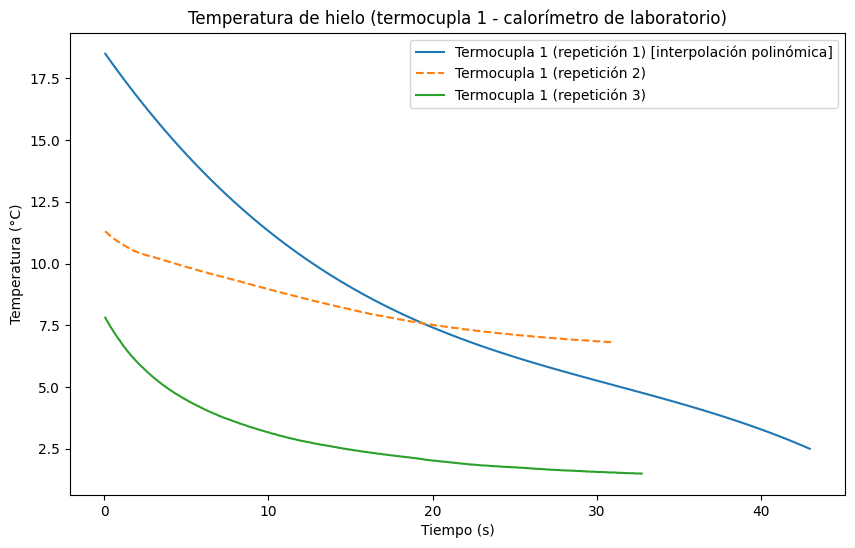

In [153]:
# Calorímetro de laboratorio - termocupla 1

# Para solucionar el cálculo de la gradiente de la repetición 1, se aplicó la interpolación polinómica de orden 3 para suavizar los datos y así lograr una curva regular como en
# las otras repeticiones. Esto es porque se permite preservar tendencias generales y cambios en los datos originales mientras se reduce el ruido, ya que construye una función polinómica
# que pase exactamente por un conjunto dado de puntos de datos.

d4_ip = interpolacion_polinomica(d4['Tiempo'], d4['Termocupla_1'])
x = d4_ip[0]
y = d4_ip[1]

df4_ip = pd.DataFrame({'Tiempo': x,'Termocupla_1': y })

plt.figure(figsize=(10, 6))
plt.plot(df4_ip['Tiempo'], df4_ip['Termocupla_1'], label='Termocupla 1 (repetición 1) [interpolación polinómica]')
plt.plot(d5['Tiempo'], d5['Termocupla_1'], label='Termocupla 1 (repetición 2)', linestyle='dashed')
plt.plot(d6['Tiempo'], d6['Termocupla_1'], label='Termocupla 1 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de hielo (termocupla 1 - calorímetro de laboratorio)')
plt.legend()

print("Diferencias promedios de la temperatura medida del hielo en calorímetro de laboratorio (termocupla 1):")
dif_d4_d5 = round(abs(np.mean([y]) - np.mean([d5['Termocupla_1']])),2)
dif_d4_d6 = round(abs(np.mean([y]) - np.mean([d6['Termocupla_1']])),2)
print('· repetición 1 [interpolación polinómica] con repetición 2: '+str(dif_d4_d5)+' ºC')
print('· repetición 1 [interpolación polinómica] con repetición 3: '+str(dif_d4_d6)+' ºC')

dif_d5_d6 = round(abs(np.mean([d5['Termocupla_1']]) - np.mean([d6['Termocupla_1']])),2)
print('· repetición 2 con repetición 3: '+str(dif_d5_d6)+' ºC'+'\n')

dif_d4_d5 = round(abs(np.mean([d4['Termocupla_1']]) - np.mean([d5['Termocupla_1']])),2)
dif_d4_d6 = round(abs(np.mean([d4['Termocupla_1']]) - np.mean([d6['Termocupla_1']])),2)
print('· repetición 1 con repetición 2: '+str(dif_d4_d5)+' ºC')
print('· repetición 1 con repetición 3: '+str(dif_d4_d6)+' ºC'+'\n')

plt.show()

In [154]:
# Se observa que las diferencias promedios de la repetición 1 original y la que posee interpolación polinómica son cercanas. Manteniendo en gran parte el comportamiento de los datos.

Tasa de enfriamiento (interpolada polinómicamente) promedio del Calorímetro de laboratorio [repetición 1]: -0.37 °C/s
Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 2]: -0.15 °C/s
Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 3]: -0.19 °C/s



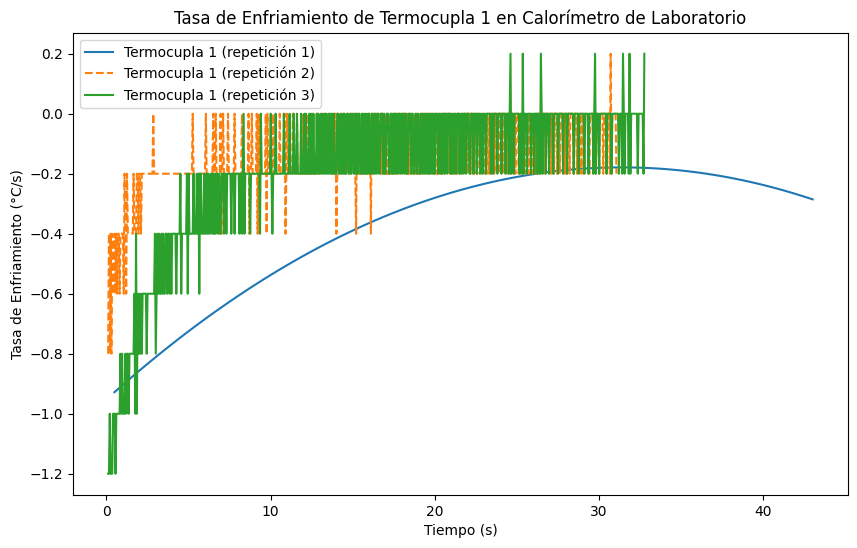

In [155]:
# Calorímetro de laboratorio - termocupla 1

# Ahora se vuelve a calcular la gradiente para obtener la tasa de enfriamiento para cada medición realizada.

df4_ip['tasa_enfriamiento_1'] = df4_ip['Termocupla_1'].diff()/df4_ip['Tiempo'].diff()
d5['tasa_enfriamiento_2'] = d5['Termocupla_1'].diff()/d5['Tiempo'].diff()
d6['tasa_enfriamiento_3'] = d6['Termocupla_1'].diff()/d6['Tiempo'].diff()

# Se ordenan los datos para su graficación organizada.
plt.figure(figsize=(10, 6))
plt.plot(df4_ip['Tiempo'], df4_ip['tasa_enfriamiento_1'], label='Termocupla 1 (repetición 1)')
plt.plot(d5['Tiempo'], d5['tasa_enfriamiento_2'], label='Termocupla 1 (repetición 2)', linestyle='dashed')
plt.plot(d6['Tiempo'], d6['tasa_enfriamiento_3'], label='Termocupla 1 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento de Termocupla 1 en Calorímetro de Laboratorio')
plt.legend()

# Se calculan la tasa de enfriamiento promedio de cada repetición 1.

tasa_promedio_1 = round(df4_ip['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d5['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d6['tasa_enfriamiento_3'].mean(),2)

print(f'Tasa de enfriamiento (interpolada polinómicamente) promedio del Calorímetro de laboratorio [repetición 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 2]: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 3]: {tasa_promedio_3} °C/s'+'\n')

plt.show()

In [156]:
# La tasa de enfriamiento para la repetición 1 es regular debido a la interpolación polinómica, sin embargo, en cuando la tasa promedio de enfriamiento,
# es cercana a la obtenida en la gradiente calculada con los datos originales.

Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 1]: -0.37 °C/s
Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 2]: -0.15 °C/s
Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 3]: -0.19 °C/s

Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 1]: -0.37 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 2]: -0.14 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 3]: -0.19 °C/s



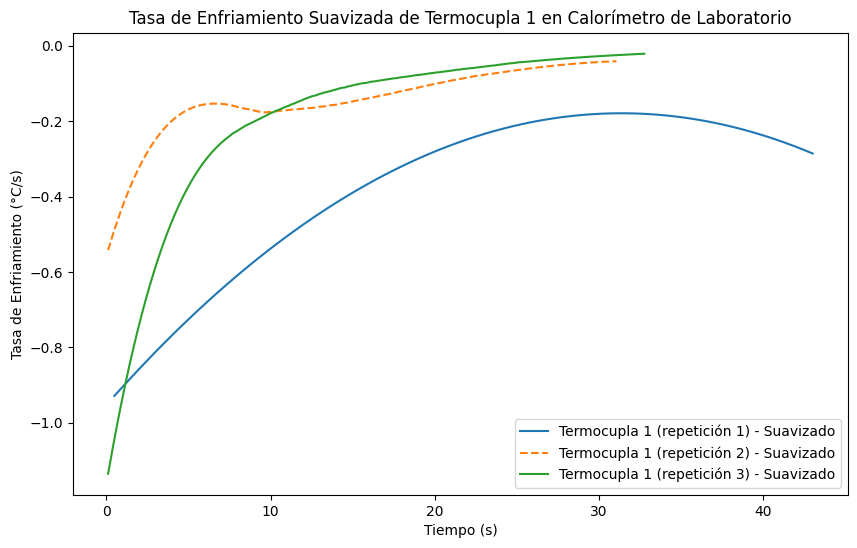

In [157]:
# Entonces se realiza el filtro uniforme 1-D y el filtro de Savitzky-Golay para analizar de mejor forma la tasa de enfriamiento.

# Calcular la tasa de enfriamiento
df4_ip['tasa_enfriamiento_1'] = df4_ip['Termocupla_1'].diff() / df4_ip['Tiempo'].diff()
d5['tasa_enfriamiento_2'] = d5['Termocupla_1'].diff() / d5['Tiempo'].diff()
d6['tasa_enfriamiento_3'] = d6['Termocupla_1'].diff() / d6['Tiempo'].diff()

df4_ip.dropna(subset=['tasa_enfriamiento_1'], inplace=True)
d5.dropna(subset=['tasa_enfriamiento_2'], inplace=True)
d6.dropna(subset=['tasa_enfriamiento_3'], inplace=True)

# Suavizar los datos usando una media móvil
window_size = 300  # Ajusta este valor según sea necesario
poly_order = 3    # Orden del polinomio

df4_ip['tasa_enfriamiento_1_suavizada'] = df4_ip['tasa_enfriamiento_1']
d5['tasa_enfriamiento_2_suavizada'] = savgol_filter(uniform_filter1d(d5['tasa_enfriamiento_2'], size=4), window_size, poly_order)
d6['tasa_enfriamiento_3_suavizada'] = savgol_filter(uniform_filter1d(d6['tasa_enfriamiento_3'], size=4), window_size, poly_order)

# Graficar los datos suavizados
plt.figure(figsize=(10, 6))
plt.plot(df4_ip['Tiempo'], df4_ip['tasa_enfriamiento_1_suavizada'], label='Termocupla 1 (repetición 1) - Suavizado')
plt.plot(d5['Tiempo'], d5['tasa_enfriamiento_2_suavizada'], label='Termocupla 1 (repetición 2) - Suavizado', linestyle='dashed')
plt.plot(d6['Tiempo'], d6['tasa_enfriamiento_3_suavizada'], label='Termocupla 1 (repetición 3) - Suavizado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento Suavizada de Termocupla 1 en Calorímetro de Laboratorio')
plt.legend()

tasa_promedio_1 = round(df4_ip['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d5['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d6['tasa_enfriamiento_3'].mean(),2)

tasa_promedio_1s = round(df4_ip['tasa_enfriamiento_1_suavizada'].mean(),2)
tasa_promedio_2s = round(d5['tasa_enfriamiento_2_suavizada'].mean(),2)
tasa_promedio_3s = round(d6['tasa_enfriamiento_3_suavizada'].mean(),2)

# Se realizan los cálculos de la tasa de enfriamiento promedio de los datos originales y los suavizados para compararlos.

print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 2]: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 3]: {tasa_promedio_3} °C/s'+'\n')

print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 1]: {tasa_promedio_1s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 2]: {tasa_promedio_2s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 3]: {tasa_promedio_3s} °C/s'+'\n')

plt.show()

In [158]:
# Se observa mejor la tendencia de la tasa de enfriamiento en la repetición 1, además de que el promedio de esta no es tan alejado del de los datos originales.

Parámetros del ajuste exponencial (repetición 1): a=16.83, b=0.05, c=1.47 => T = [16.83*e^(-0.05*t)]+1.47 || R^2=0.9717
Parámetros del ajuste exponencial (repetición 2): a=5.48, b=0.05, c=5.63 => T = [5.48*e^(-0.05*t)]+5.63 || R^2=0.9983
Parámetros del ajuste exponencial (repetición 3): a=5.88, b=0.13, c=1.52 => T = [5.88*e^(-0.13*t)]+1.52 || R^2=0.9964

Parámetros del ajuste exponencial promedios: a=9.4, b=0.08, c=2.88



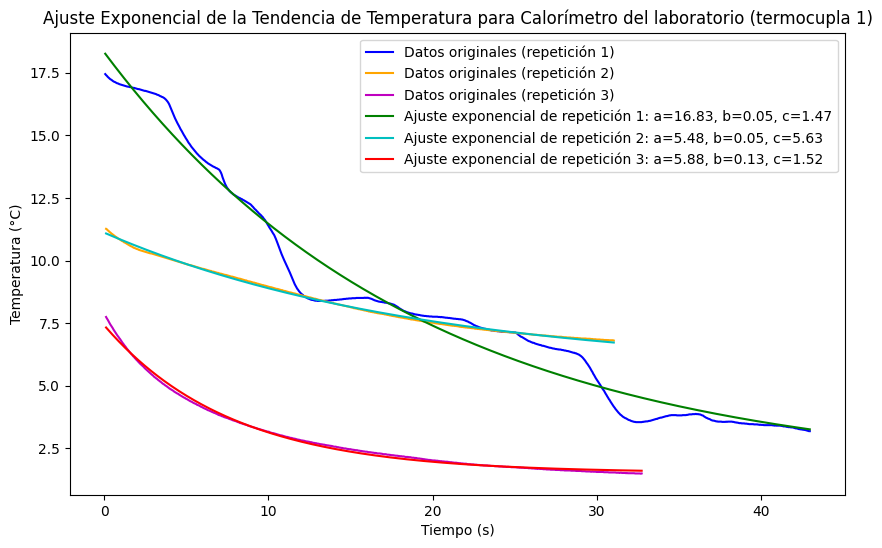

In [224]:
# Para mayor análisis, ahora se ajustarán las mediciones de cada repetición con la ecuación de  la función mono exponencial,
# ya que la tendencia que siguen los datos medidos se asemeja mucho a la de ese tipo de función.

# Función exponencial
def monoExp(x, a, b, c):
    return a * np.exp(-b * x) + c

# Ajustar una curva exponencial a los datos

popt_4, pcov_4 = curve_fit(monoExp, d4['Tiempo'].dropna(), d4['Termocupla_1'].dropna())
popt_5, pcov_5 = curve_fit(monoExp, d5['Tiempo'].dropna(), d5['Termocupla_1'].dropna())
popt_6, pcov_6 = curve_fit(monoExp, d6['Tiempo'].dropna(), d6['Termocupla_1'].dropna())

# Generar datos para la curva ajustada
tiempo_fit_4 = np.linspace(d4['Tiempo'].min(), d4['Tiempo'].max(), 50000)
tasa_fit_4 = monoExp(tiempo_fit_4, *popt_4)

tiempo_fit_5 = np.linspace(d5['Tiempo'].min(), d5['Tiempo'].max(), 500)
tasa_fit_5 = monoExp(tiempo_fit_5, *popt_5)

tiempo_fit_6 = np.linspace(d6['Tiempo'].min(), d6['Tiempo'].max(), 500)
tasa_fit_6 = monoExp(tiempo_fit_6, *popt_6)

# Calcular R^2 para cada ajuste
R2_4 = calcular_R2(d4['Termocupla_1'].dropna(), monoExp(d4['Tiempo'].dropna(), *popt_4))
R2_5 = calcular_R2(d5['Termocupla_1'].dropna(), monoExp(d5['Tiempo'].dropna(), *popt_5))
R2_6 = calcular_R2(d6['Termocupla_1'].dropna(), monoExp(d6['Tiempo'].dropna(), *popt_6))


# Graficar los datos y la curva ajustada
plt.figure(figsize=(10, 6))
plt.plot(d4['Tiempo'], d4['Termocupla_1'], 'b-', label='Datos originales (repetición 1)')
plt.plot(d5['Tiempo'], d5['Termocupla_1'], 'orange', label='Datos originales (repetición 2)')
plt.plot(d6['Tiempo'], d6['Termocupla_1'], 'm-', label='Datos originales (repetición 3)')

plt.plot(tiempo_fit_4, tasa_fit_4, 'g-', label='Ajuste exponencial de repetición 1: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_4))
plt.plot(tiempo_fit_5, tasa_fit_5, 'c-', label='Ajuste exponencial de repetición 2: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_5))
plt.plot(tiempo_fit_6, tasa_fit_6, 'r-', label='Ajuste exponencial de repetición 3: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_6))

plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Ajuste Exponencial de la Tendencia de Temperatura para Calorímetro del laboratorio (termocupla 1)')
plt.legend()

print(f'Parámetros del ajuste exponencial (repetición 1): a={round(popt_4[0],2)}, b={round(popt_4[1],2)}, c={round(popt_4[2],2)} => T = [{round(popt_4[0],2)}*e^(-{round(popt_4[1],2)}*t)]+{round(popt_4[2],2)} || R^2={R2_4:.4f}')
print(f'Parámetros del ajuste exponencial (repetición 2): a={round(popt_5[0],2)}, b={round(popt_5[1],2)}, c={round(popt_5[2],2)} => T = [{round(popt_5[0],2)}*e^(-{round(popt_5[1],2)}*t)]+{round(popt_5[2],2)} || R^2={R2_5:.4f}')
print(f'Parámetros del ajuste exponencial (repetición 3): a={round(popt_6[0],2)}, b={round(popt_6[1],2)}, c={round(popt_6[2],2)} => T = [{round(popt_6[0],2)}*e^(-{round(popt_6[1],2)}*t)]+{round(popt_6[2],2)} || R^2={R2_6:.4f}')
print()

print(f'Parámetros del ajuste exponencial promedios: a={round((popt_4[0]+popt_5[0]+popt_6[0])/3,2)}, b={round((popt_4[1]+popt_5[1]+popt_6[1])/3,2)}, c={round((popt_4[2]+popt_5[2]+popt_6[2])/3,2)}')
print()
plt.show()

In [160]:
# El obtener la ecuación para las mediciones de cada repetición ayuda a la predicción de datos y cómo se comporta lo que es el intercambio de temperatura
# en el calorímetro de laboratorio.

Análisis de varianza (ANOVA) de la temperatura medida del hielo (termocupla 1 - calorímetro de laboratorio)

Estadístico F: 1709.6553970616965
Valor p: 0.0
Hay diferencias significativas entre al menos dos grupos.



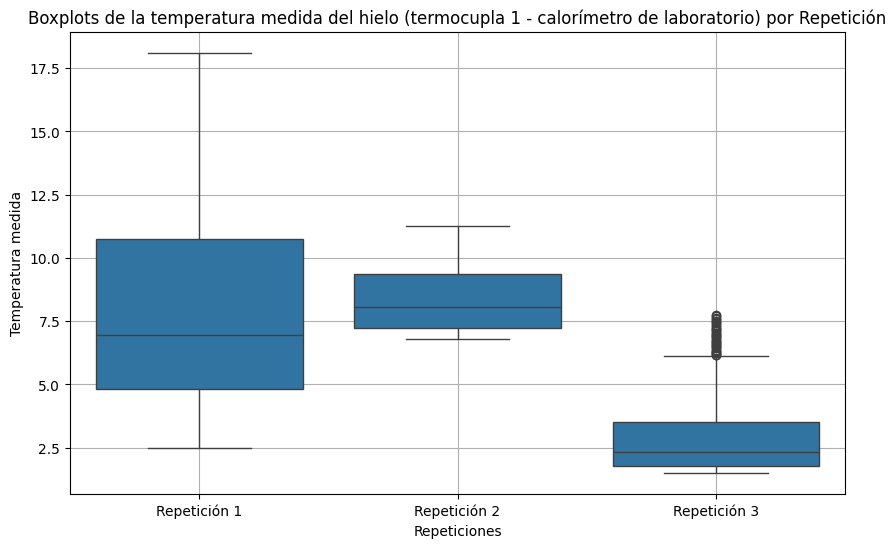

In [161]:
# Se realiza un ANOVA para ver la varianza entre las mediciones realizadas y es gráficado en boxplots para un entendimiento gráfico de este aspécto
# estadístico.

df = pd.DataFrame({
    'Grupo': ['Repetición 1'] * len(df4_ip['Termocupla_1']) + ['Repetición 2'] * len(d5['Termocupla_1']) + ['Repetición 3'] * len(d6['Termocupla_1']),
    'Termocupla_1': pd.concat([df4_ip['Termocupla_1'], d5['Termocupla_1'], d6['Termocupla_1']])
})

# Graficar boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Grupo', y='Termocupla_1', data=df)
plt.title('Boxplots de la temperatura medida del hielo (termocupla 1 - calorímetro de laboratorio) por Repetición')
plt.xlabel('Repeticiones')
plt.ylabel('Temperatura medida')
plt.grid(True)


# Aplicar ANOVA
statistic, p_value = f_oneway(df4_ip['Termocupla_1'], d5['Termocupla_1'], d6['Termocupla_1'])

# Mostrar resultados
print('Análisis de varianza (ANOVA) de la temperatura medida del hielo (termocupla 1 - calorímetro de laboratorio)\n')
print(f'Estadístico F: {statistic}')
print(f'Valor p: {p_value}')

# Interpretación del resultado
alpha = 0.05
if p_value < alpha:
    print('Hay diferencias significativas entre al menos dos grupos.')
else:
    print('No hay evidencia suficiente para afirmar diferencias significativas entre los grupos.')
print()
plt.show()

In [162]:
# A pesar de que los datos de la repetición 1 y 2 tengan cercania, existen ciertas diferencias en cuanto al rango de los valores de temperatura, la posición de la media
# y también la lejanía de la repetición 3 con las otras repeticiones y el hecho de que este posee valores atípicos.

# El estadístico F es de gran magnitud, denotando la varianza mencionada.

### Calorímetro casero, termocupla 2, medición de hielo

Diferencias promedios de la temperatura medida del hielo en calorímetro casero (termocupla 2):
· repetición 1 con repetición 2: 6.36 ºC
· repetición 1 con repetición 3: 5.75 ºC
· repetición 2 con repetición 3: 0.62 ºC



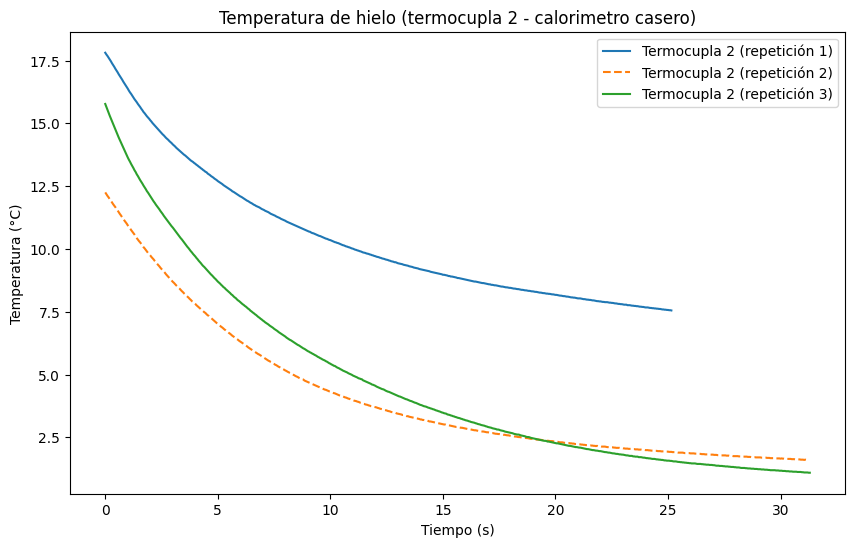

In [163]:
# Calorímetro casero - termocupla 2
# Ahora para analizar los datos obtenidos de la termocupla 2 dentro del calorímetro casero, primero se ordenan gráficamente
# para visualizar la tendencia y lejanía entre estos.

plt.figure(figsize=(10, 6))
plt.plot(d7['Tiempo'], d7['Termocupla_2'], label='Termocupla 2 (repetición 1)')
plt.plot(d8['Tiempo'], d8['Termocupla_2'], label='Termocupla 2 (repetición 2)', linestyle='dashed')
plt.plot(d9['Tiempo'], d9['Termocupla_2'], label='Termocupla 2 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de hielo (termocupla 2 - calorimetro casero)')
plt.legend()

print("Diferencias promedios de la temperatura medida del hielo en calorímetro casero (termocupla 2):")
dif_d7_d8 = round(abs(np.mean([d7['Termocupla_2']]) - np.mean([d8['Termocupla_2']])),2)
dif_d7_d9 = round(abs(np.mean([d7['Termocupla_2']]) - np.mean([d9['Termocupla_2']])),2)
print('· repetición 1 con repetición 2: '+str(dif_d7_d8)+' ºC')
print('· repetición 1 con repetición 3: '+str(dif_d7_d9)+' ºC')

dif_d8_d9 = round(abs(np.mean([d8['Termocupla_2']]) - np.mean([d9['Termocupla_2']])),2)
print('· repetición 2 con repetición 3: '+str(dif_d8_d9)+' ºC'+'\n')

plt.show()

In [164]:
# Se observa que a diferencia de las mediciones con la termocupla 1 dentro del calorímetro de laboratorio, con las mediciones realizadas
# con la termocupla 2 dentro del calorímetro casero, las mediciones son regulares y más cercanas entre sí.

Tasa de enfriamiento promedio del Calorímetro casero [repetición 1]: -0.41 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [repetición 2]: -0.34 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [repetición 3]: -0.47 °C/s



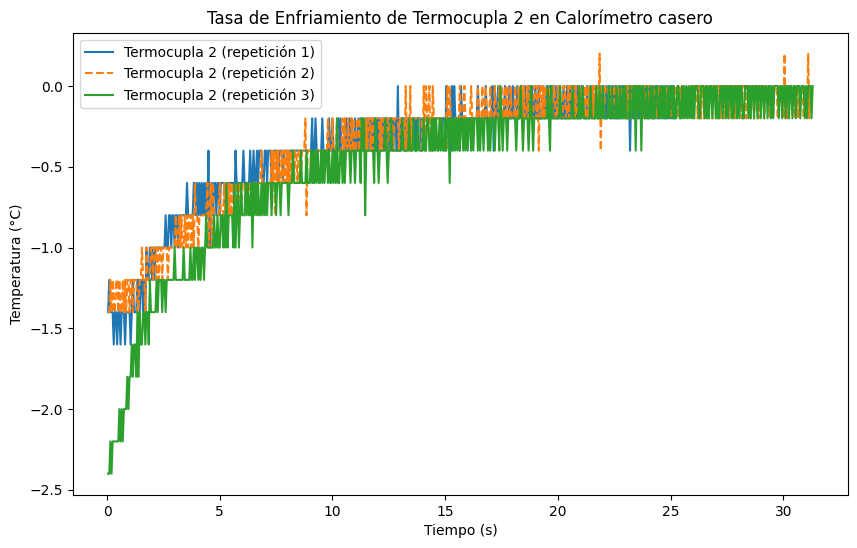

In [165]:
# Calorímetro casero - termocupla 2

# Se calcula la tasa de enfriamiento presentada en los datos medidos a través de la gradiente de los mismos.
d7['tasa_enfriamiento_1'] = d7['Termocupla_2'].diff()/d7['Tiempo'].diff()
d8['tasa_enfriamiento_2'] = d8['Termocupla_2'].diff()/d8['Tiempo'].diff()
d9['tasa_enfriamiento_3'] = d9['Termocupla_2'].diff()/d9['Tiempo'].diff()

# Se ordenan los datos para graficarlos
plt.figure(figsize=(10, 6))
plt.plot(d7['Tiempo'], d7['tasa_enfriamiento_1'], label='Termocupla 2 (repetición 1)')
plt.plot(d8['Tiempo'], d8['tasa_enfriamiento_2'], label='Termocupla 2 (repetición 2)', linestyle='dashed')
plt.plot(d9['Tiempo'], d9['tasa_enfriamiento_3'], label='Termocupla 2 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Tasa de Enfriamiento de Termocupla 2 en Calorímetro casero')
plt.legend()

# Se obtiene el promedio de la tasa de enfriamiento para la comprención de la tendencia de ello
tasa_promedio_1 = round(d7['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d8['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d9['tasa_enfriamiento_3'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 2]: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 3]: {tasa_promedio_3} °C/s'+'\n')

plt.show()

In [166]:
# Debido a que al obtener la gradiante y graficar los datos, la curva que gráfican presenta muchas irregularidades, por lo tanto se debe de suavizar.

Tasa de enfriamiento promedio del Calorímetro casero [repetición 1]: -0.41 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [repetición 2]: -0.34 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [repetición 3]: -0.47 °C/s

Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 1]: -0.41 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 2]: -0.34 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 3]: -0.47 °C/s



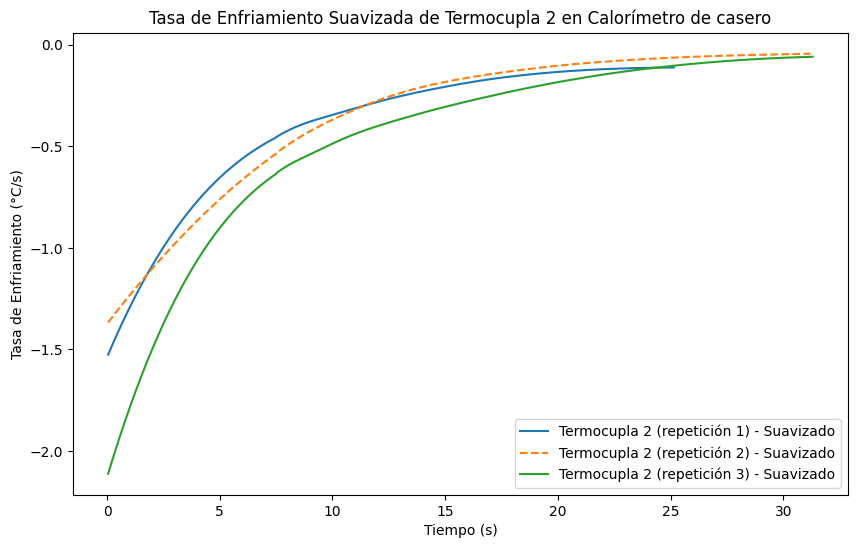

In [167]:
# Se aplica el filtrado uniforme 1-D y luego el filtro de Savitzky-Golay para una suavización adecuada de los datos en
# la tasa de enfriamiento para cada repetición para mantener la tendencia y comportamiento de los datos originales.

# Calcular la tasa de enfriamiento
d7['tasa_enfriamiento_1'] = d7['Termocupla_2'].diff() / d7['Tiempo'].diff()
d8['tasa_enfriamiento_2'] = d8['Termocupla_2'].diff() / d8['Tiempo'].diff()
d9['tasa_enfriamiento_3'] = d9['Termocupla_2'].diff() / d9['Tiempo'].diff()

d7.dropna(subset=['tasa_enfriamiento_1'], inplace=True)
d8.dropna(subset=['tasa_enfriamiento_2'], inplace=True)
d9.dropna(subset=['tasa_enfriamiento_3'], inplace=True)

# Suavizar los datos usando una media móvil
window_size = 300  # Ajusta este valor según sea necesario
poly_order = 3    # Orden del polinomio

d7['tasa_enfriamiento_1_suavizada'] = savgol_filter(uniform_filter1d(d7['tasa_enfriamiento_1'], size=50), window_size, poly_order)
d8['tasa_enfriamiento_2_suavizada'] = savgol_filter(uniform_filter1d(d8['tasa_enfriamiento_2'], size=50), window_size, poly_order)
d9['tasa_enfriamiento_3_suavizada'] = savgol_filter(uniform_filter1d(d9['tasa_enfriamiento_3'], size=50), window_size, poly_order)

# Graficar los datos suavizados
plt.figure(figsize=(10, 6))
plt.plot(d7['Tiempo'], d7['tasa_enfriamiento_1_suavizada'], label='Termocupla 2 (repetición 1) - Suavizado')
plt.plot(d8['Tiempo'], d8['tasa_enfriamiento_2_suavizada'], label='Termocupla 2 (repetición 2) - Suavizado', linestyle='dashed')
plt.plot(d9['Tiempo'], d9['tasa_enfriamiento_3_suavizada'], label='Termocupla 2 (repetición 3) - Suavizado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento Suavizada de Termocupla 2 en Calorímetro de casero')
plt.legend()

tasa_promedio_1 = round(d7['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d8['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d9['tasa_enfriamiento_3'].mean(),2)

tasa_promedio_1s = round(d7['tasa_enfriamiento_1_suavizada'].mean(),2)
tasa_promedio_2s = round(d8['tasa_enfriamiento_2_suavizada'].mean(),2)
tasa_promedio_3s = round(d9['tasa_enfriamiento_3_suavizada'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 2]: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 3]: {tasa_promedio_3} °C/s'+'\n')

print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 1]: {tasa_promedio_1s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 2]: {tasa_promedio_2s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 3]: {tasa_promedio_3s} °C/s'+'\n')

plt.show()


Parámetros del ajuste exponencial (repetición 1): a=10.18, b=0.12, c=7.25 => T = [10.18*e^(-0.12*t)]+7.25 || R^2=0.9986
Parámetros del ajuste exponencial (repetición 2): a=10.7, b=0.13, c=1.54 => T = [10.7*e^(-0.13*t)]+1.54 || R^2=0.9998
Parámetros del ajuste exponencial (repetición 3): a=14.34, b=0.11, c=0.77 => T = [14.34*e^(-0.11*t)]+0.77 || R^2=0.9992

Parámetros del ajuste exponencial promedios: a=11.74, b=0.12, c=3.19



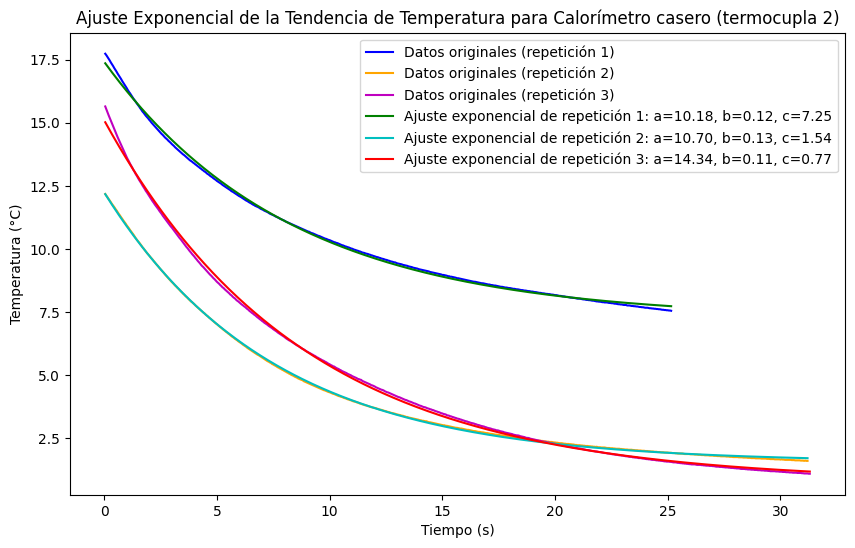

In [223]:
# Se hace un ajuste de los datos de las mediciones con la termocupla 2 a la ecuación mono-exponencial para asi obtener una función que
# explique el comportamiento de las mediciones realizadas y poder realizar predicciones.

# Función exponencial
def monoExp(x, a, b, c):
    return a * np.exp(-b * x) + c

# Ajustar una curva exponencial a los datos
popt_7, pcov_7 = curve_fit(monoExp, d7['Tiempo'].dropna(), d7['Termocupla_2'].dropna())
popt_8, pcov_8 = curve_fit(monoExp, d8['Tiempo'].dropna(), d8['Termocupla_2'].dropna())
popt_9, pcov_9 = curve_fit(monoExp, d9['Tiempo'].dropna(), d9['Termocupla_2'].dropna())

# Generar datos para la curva ajustada
tiempo_fit_7 = np.linspace(d7['Tiempo'].min(), d7['Tiempo'].max(), 50000)
tasa_fit_7 = monoExp(tiempo_fit_7, *popt_7)

tiempo_fit_8 = np.linspace(d8['Tiempo'].min(), d8['Tiempo'].max(), 500)
tasa_fit_8 = monoExp(tiempo_fit_8, *popt_8)

tiempo_fit_9 = np.linspace(d9['Tiempo'].min(), d9['Tiempo'].max(), 500)
tasa_fit_9 = monoExp(tiempo_fit_9, *popt_9)

# Calcular R^2 para cada ajuste
R2_7 = calcular_R2(d7['Termocupla_2'].dropna(), monoExp(d7['Tiempo'].dropna(), *popt_7))
R2_8 = calcular_R2(d8['Termocupla_2'].dropna(), monoExp(d8['Tiempo'].dropna(), *popt_8))
R2_9 = calcular_R2(d9['Termocupla_2'].dropna(), monoExp(d9['Tiempo'].dropna(), *popt_9))


# Graficar los datos y la curva ajustada
plt.figure(figsize=(10, 6))
plt.plot(d7['Tiempo'], d7['Termocupla_2'], 'b-', label='Datos originales (repetición 1)')
plt.plot(d8['Tiempo'], d8['Termocupla_2'], 'orange', label='Datos originales (repetición 2)')
plt.plot(d9['Tiempo'], d9['Termocupla_2'], 'm-', label='Datos originales (repetición 3)')

plt.plot(tiempo_fit_7, tasa_fit_7, 'g-', label='Ajuste exponencial de repetición 1: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_7))
plt.plot(tiempo_fit_8, tasa_fit_8, 'c-', label='Ajuste exponencial de repetición 2: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_8))
plt.plot(tiempo_fit_9, tasa_fit_9, 'r-', label='Ajuste exponencial de repetición 3: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_9))

plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Ajuste Exponencial de la Tendencia de Temperatura para Calorímetro casero (termocupla 2)')
plt.legend()

print(f'Parámetros del ajuste exponencial (repetición 1): a={round(popt_7[0],2)}, b={round(popt_7[1],2)}, c={round(popt_7[2],2)} => T = [{round(popt_7[0],2)}*e^(-{round(popt_7[1],2)}*t)]+{round(popt_7[2],2)} || R^2={R2_7:.4f}')
print(f'Parámetros del ajuste exponencial (repetición 2): a={round(popt_8[0],2)}, b={round(popt_8[1],2)}, c={round(popt_8[2],2)} => T = [{round(popt_8[0],2)}*e^(-{round(popt_8[1],2)}*t)]+{round(popt_8[2],2)} || R^2={R2_8:.4f}')
print(f'Parámetros del ajuste exponencial (repetición 3): a={round(popt_9[0],2)}, b={round(popt_9[1],2)}, c={round(popt_9[2],2)} => T = [{round(popt_9[0],2)}*e^(-{round(popt_9[1],2)}*t)]+{round(popt_9[2],2)} || R^2={R2_9:.4f}')
print()

print(f'Parámetros del ajuste exponencial promedios: a={round((popt_7[0]+popt_8[0]+popt_9[0])/3,2)}, b={round((popt_7[1]+popt_8[1]+popt_9[1])/3,2)}, c={round((popt_7[2]+popt_8[2]+popt_9[2])/3,2)}')
print()
plt.show()

In [169]:
# Los valores de "b" dentro del ajusto exponencial son altamente similares entre sí, denotando que las mediciones siguen un tipo de decrecimiento
# altamente similar entre sí. Además las mediciones realizadas están dentro de lo que se espera para el comportamiento del cambio de temperatura en
# un cuerpo, por lo cual el R^2 para las tendencias obtenidas es sumamente cercano a 1, por eso coinciden mucho el ajuste exponencial con las mediciones hechas.

Análisis de varianza (ANOVA) de la temperatura medida del hielo (termocupla 2 - calorímetro casero)

Estadístico F: 707.6730693109064
Valor p: 6.1621954244557274e-226
Hay diferencias significativas entre al menos dos grupos.



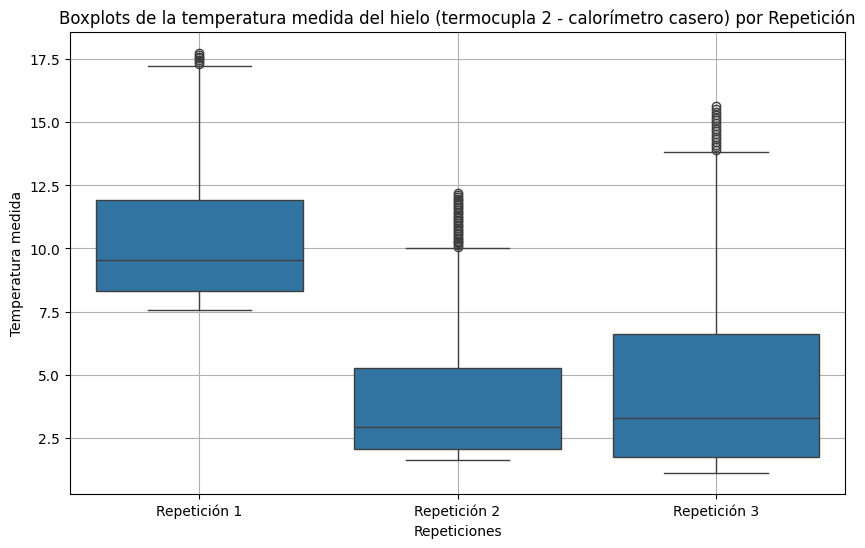

In [170]:
# Se realiza un ANOVA para estudiar la varianza que existen entre las mediciones de la termocupla 1 dentro del calorímetro casero
# porque sí bien es cierto que son cercanos los valores medidos visualmente, estadísticamente existe una variabilidad que puede ser
# significativa.

df = pd.DataFrame({
    'Grupo': ['Repetición 1'] * len(d7['Termocupla_2']) + ['Repetición 2'] * len(d8['Termocupla_2']) + ['Repetición 3'] * len(d9['Termocupla_2']),
    'Termocupla_2': pd.concat([d7['Termocupla_2'], d8['Termocupla_2'], d9['Termocupla_2']])
})

# Graficar boxplots para comprensión gráfica de la varianza entre los datos medidos
plt.figure(figsize=(10, 6))
sns.boxplot(x='Grupo', y='Termocupla_2', data=df)
plt.title('Boxplots de la temperatura medida del hielo (termocupla 2 - calorímetro casero) por Repetición')
plt.xlabel('Repeticiones')
plt.ylabel('Temperatura medida')
plt.grid(True)


# Aplicar ANOVA
statistic, p_value = f_oneway(d7['Termocupla_2'], d8['Termocupla_2'], d9['Termocupla_2'])

# Mostrar resultados
print('Análisis de varianza (ANOVA) de la temperatura medida del hielo (termocupla 2 - calorímetro casero)\n')
print(f'Estadístico F: {statistic}')
print(f'Valor p: {p_value}')

# Interpretación del resultado
alpha = 0.05
if p_value < alpha:
    print('Hay diferencias significativas entre al menos dos grupos.')
else:
    print('No hay evidencia suficiente para afirmar diferencias significativas entre los grupos.')
print()
plt.show()

In [171]:
# Se observa que el estadístico F es de una magnitud grande pero no muy grande como anteriores. Esto indica que a pesar de que los datos
# presenten una cercanía, estos siguen teniendo varianza considerable. La repetición 1 está alejada de la 2 y 3; mientras que las repeticiones
# 2 y 3 tienen una media cercana pero los rangos de los datos son distintos.
# Además es visto que en cada repetición se denotan valores atípicos.

### **Mediciones de mezcla de agua con hielo en cada calorímetro**



*   Calorímetro del laboratorio: termocupla 1
*   Calorímetro casero: termocupla 2



In [172]:
# Se inicializan los datos referentes a las mediciones realizadas a la mezcla de agua y hielo en los calorímetros.

f10 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep1/temp4_mezcla_de_agua_hielo.csv'
f11 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep2/temp4_mezcla_de_agua_hielo.csv'
f12 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteA/rep3/temp4_mezcla_de_agua_hielo.csv'

d10 = pd.read_csv(f10)
d11 = pd.read_csv(f11)
d12 = pd.read_csv(f12)

Diferencias promedios de la temperatura medida de la mezcla de agua con hielo en calorímetro de laboratorio (termocupla 1):
· repetición 1 con repetición 2: 3.75 ºC
· repetición 1 con repetición 3: 3.52 ºC
· repetición 2 con repetición 3: 0.23 ºC



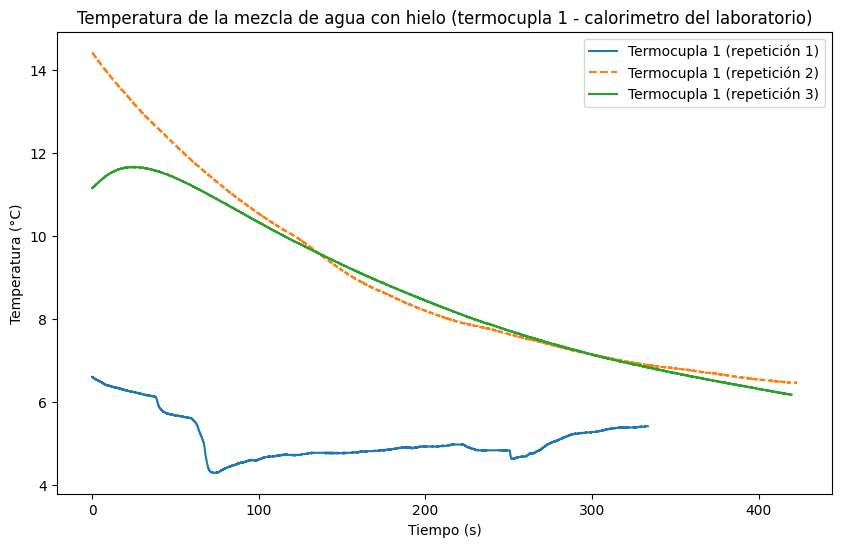

In [173]:
# Las mediciones de la mezcla de agua con hielo con la termocupla 1 dentro del calorímetro de laboratorio
# se organizan para entonces ser graficadas.

# Calorímetro del laboratorio - termocupla 1
plt.figure(figsize=(10, 6))
plt.plot(d10['Tiempo'], d10['Termocupla_1'], label='Termocupla 1 (repetición 1)')
plt.plot(d11['Tiempo'], d11['Termocupla_1'], label='Termocupla 1 (repetición 2)', linestyle='dashed')
plt.plot(d12['Tiempo'], d12['Termocupla_1'], label='Termocupla 1 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de la mezcla de agua con hielo (termocupla 1 - calorimetro del laboratorio)')
plt.legend()

print("Diferencias promedios de la temperatura medida de la mezcla de agua con hielo en calorímetro de laboratorio (termocupla 1):")
dif_d10_d11 = round(abs(np.mean([d10['Termocupla_1']]) - np.mean([d11['Termocupla_1']])),2)
dif_d10_d12 = round(abs(np.mean([d10['Termocupla_1']]) - np.mean([d12['Termocupla_1']])),2)
print('· repetición 1 con repetición 2: '+str(dif_d10_d11)+' ºC')
print('· repetición 1 con repetición 3: '+str(dif_d10_d12)+' ºC')

dif_d11_d12 = round(abs(np.mean([d11['Termocupla_1']]) - np.mean([d12['Termocupla_1']])),2)
print('· repetición 2 con repetición 3: '+str(dif_d11_d12)+' ºC'+'\n')

plt.show()

In [174]:
# Las diferencias promedios de la repetición 1 con las repeticiones 2 y 3 es similares entre sí por el tipo de tendencia y cercanía que
# tienen dichas mediciones, puesto que la diferencia promedio de la repetición 2 con la 3 es mínima.
# También la repetición 1 presenta una tendencia irregular con respecto a las curvas que trazan las otras mediciones obtenidas.

Diferencias promedios de la temperatura medida de la mezcla de agua con hielo en calorímetro casero (termocupla 2):
· repetición 1 con repetición 2: 1.38 ºC
· repetición 1 con repetición 3: 1.8 ºC
· repetición 2 con repetición 3: 0.42 ºC



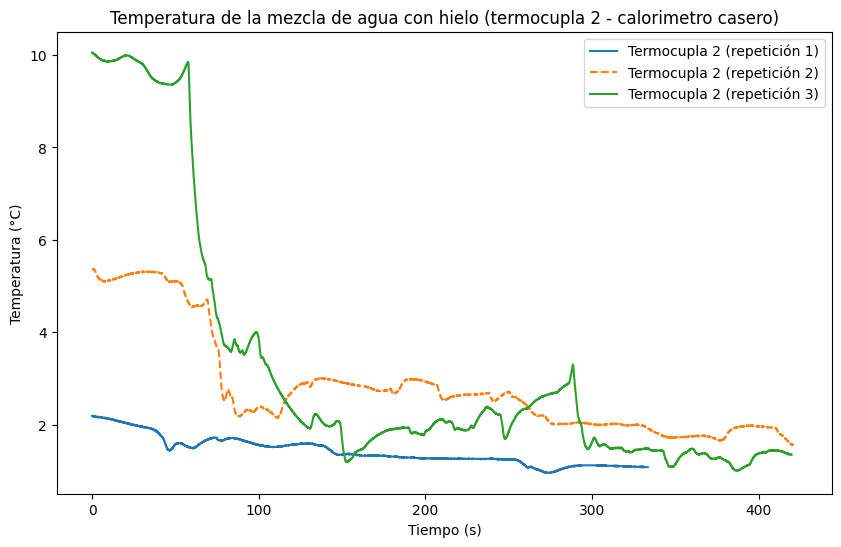

In [175]:
# Los datos obtenidos de la termocupla 2 de mezcla de agua con hielo en el calorímetro casero son inicios para ser
# arreglado en un gráfico para observer la tendencia y regularidad de los datos en sí.

# Calorimetro casero - termocupla 2
plt.figure(figsize=(10, 6))
plt.plot(d10['Tiempo'], d10['Termocupla_2'], label='Termocupla 2 (repetición 1)')
plt.plot(d11['Tiempo'], d11['Termocupla_2'], label='Termocupla 2 (repetición 2)', linestyle='dashed')
plt.plot(d12['Tiempo'], d12['Termocupla_2'], label='Termocupla 2 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de la mezcla de agua con hielo (termocupla 2 - calorimetro casero)')
plt.legend()

print("Diferencias promedios de la temperatura medida de la mezcla de agua con hielo en calorímetro casero (termocupla 2):")
dif_d10_d11 = round(abs(np.mean([d10['Termocupla_2']]) - np.mean([d11['Termocupla_2']])),2)
dif_d10_d12 = round(abs(np.mean([d10['Termocupla_2']]) - np.mean([d12['Termocupla_2']])),2)
print('· repetición 1 con repetición 2: '+str(dif_d10_d11)+' ºC')
print('· repetición 1 con repetición 3: '+str(dif_d10_d12)+' ºC')

dif_d11_d12 = round(abs(np.mean([d11['Termocupla_2']]) - np.mean([d12['Termocupla_2']])),2)
print('· repetición 2 con repetición 3: '+str(dif_d11_d12)+' ºC'+'\n')

plt.show()

In [176]:
# Los datos presentan mucha irregularidad entre estos a pesar de que siguen una tendencia curva, esto indicia que hubo ruido en las mediciones
# por contacto directo con alguna superficie además de la mezcla de agua con hielo dentro del calorímetro casero.

La aplicación de interpolación polinomial cúbica permite una mejor visualización del comportamiento de los datos de temperatura a lo largo del tiempo en el calorímetro casero. Primero con los datos de la termocupla 1 y luego con los datos de la termocupla 2.

In [177]:
# Se aplica la interpolación polinomial cúbica para suavización de los datos y reducir las irreguladirades para
# apreciar de mejor forma el comportamiento de las mediciones realizadas.

# Calorimetro del laboratorio
d10_ip_t1 = interpolacion_polinomica(d10['Tiempo'], d10['Termocupla_1'])
x = d10_ip_t1[0]
y = d10_ip_t1[1]

df10_ip_t1 = pd.DataFrame({'Tiempo': x,'Termocupla_1': y })

Diferencias promedios de la temperatura medida de la mezcla de agua con hielo en calorímetro de laboratorio (termocupla 1):
· repetición 1 [interpolación polinómica] con repetición 2: 3.75 ºC
· repetición 1 [interpolación polinómica] con repetición 3: 3.51 ºC
· repetición 1 con repetición 2: 3.75 ºC
· repetición 1 con repetición 3: 3.52 ºC
· repetición 2 con repetición 3: 0.23 ºC



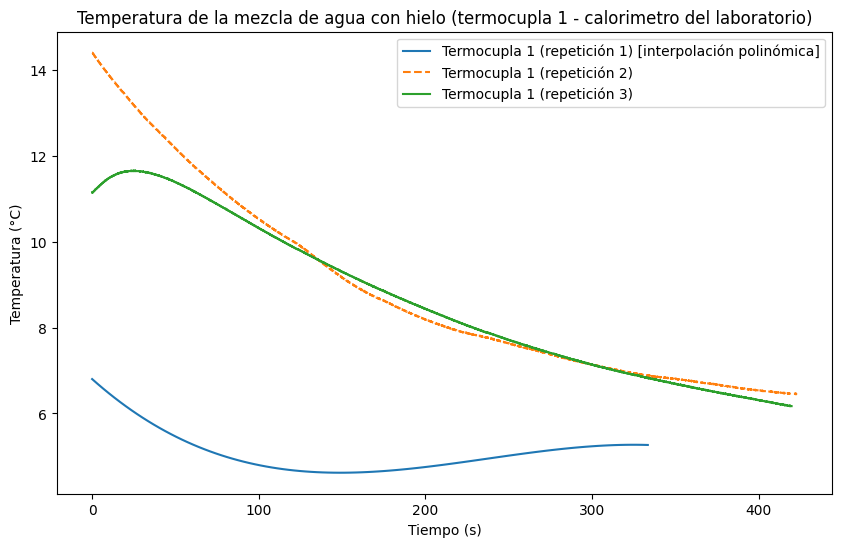

In [178]:
# Se organizan los datos para la graficación.
plt.figure(figsize=(10, 6))
plt.plot(df10_ip_t1['Tiempo'], df10_ip_t1['Termocupla_1'], label='Termocupla 1 (repetición 1) [interpolación polinómica]')
plt.plot(d11['Tiempo'], d11['Termocupla_1'], label='Termocupla 1 (repetición 2)', linestyle='dashed')
plt.plot(d12['Tiempo'], d12['Termocupla_1'], label='Termocupla 1 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de la mezcla de agua con hielo (termocupla 1 - calorimetro del laboratorio)')
plt.legend()

print("Diferencias promedios de la temperatura medida de la mezcla de agua con hielo en calorímetro de laboratorio (termocupla 1):")
dif_d10_d11 = round(abs(np.mean([df10_ip_t1['Termocupla_1']]) - np.mean([d11['Termocupla_1']])),2)
dif_d10_d12 = round(abs(np.mean([df10_ip_t1['Termocupla_1']]) - np.mean([d12['Termocupla_1']])),2)
print('· repetición 1 [interpolación polinómica] con repetición 2: '+str(dif_d10_d11)+' ºC')
print('· repetición 1 [interpolación polinómica] con repetición 3: '+str(dif_d10_d12)+' ºC')

dif_d10_d11 = round(abs(np.mean([d10['Termocupla_1']]) - np.mean([d11['Termocupla_1']])),2)
dif_d10_d12 = round(abs(np.mean([d10['Termocupla_1']]) - np.mean([d12['Termocupla_1']])),2)
print('· repetición 1 con repetición 2: '+str(dif_d10_d11)+' ºC')
print('· repetición 1 con repetición 3: '+str(dif_d10_d12)+' ºC')

dif_d11_d12 = round(abs(np.mean([d11['Termocupla_1']]) - np.mean([d12['Termocupla_1']])),2)
print('· repetición 2 con repetición 3: '+str(dif_d11_d12)+' ºC'+'\n')

plt.show()

In [179]:
# Habiendo realizado el suavizado de los datos con interpolación polinómica cúbica, las diferencias promedios de temperatura de la
# repetición 1 se mantienen siendo altamente cercanas, significando que se mantiene la información con respecto a la tendencia y
# comportamiento de la repetición 1.

In [180]:
# Se aplica interpolación polinómica cúbica a los datos medidos con la termocupla 2 para visualizar mejor la tendencia que existe
# en las mediciones.

# Calorimetro casero - termocupla 2
d10_ip_t2 = interpolacion_polinomica(d10['Tiempo'], d10['Termocupla_2'])
x = d10_ip_t2[0]
y = d10_ip_t2[1]
df10_ip_t2 = pd.DataFrame({'Tiempo': x,'Termocupla_2': y })

d11_ip_t2 = interpolacion_polinomica(d11['Tiempo'], d11['Termocupla_2'])
x = d11_ip_t2[0]
y = d11_ip_t2[1]
df11_ip_t2 = pd.DataFrame({'Tiempo': x,'Termocupla_2': y })

d12_ip_t2 = interpolacion_polinomica(d12['Tiempo'], d12['Termocupla_2'])
x = d12_ip_t2[0]
y = d12_ip_t2[1]
df12_ip_t2 = pd.DataFrame({'Tiempo': x,'Termocupla_2': y })

Diferencias promedios de la temperatura medida de la mezcla de agua con hielo en calorímetro casero (termocupla 2):
· repetición 1 [interpolación polinómica] con repetición 2 [interpolación polinómica]: 1.39 ºC
· repetición 1 [interpolación polinómica] con repetición 3 [interpolación polinómica]: 1.83 ºC
· repetición 2 [interpolación polinómica] con repetición 3 [interpolación polinómica]: 0.44 ºC
· repetición 1 con repetición 2: 1.38 ºC
· repetición 1 con repetición 3: 1.8 ºC
· repetición 2 con repetición 3: 0.42 ºC



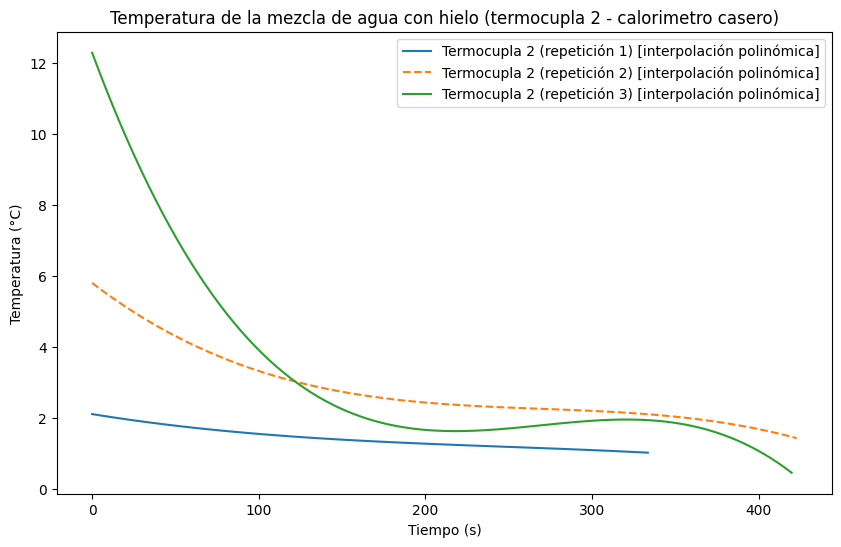

In [181]:
# Los datos procesados se grafican para poder tener una visualización de estos y ver cómo se comportan los datos.
plt.figure(figsize=(10, 6))
plt.plot(df10_ip_t2['Tiempo'], df10_ip_t2['Termocupla_2'], label='Termocupla 2 (repetición 1) [interpolación polinómica]')
plt.plot(df11_ip_t2['Tiempo'], df11_ip_t2['Termocupla_2'], label='Termocupla 2 (repetición 2) [interpolación polinómica]', linestyle='dashed')
plt.plot(df12_ip_t2['Tiempo'], df12_ip_t2['Termocupla_2'], label='Termocupla 2 (repetición 3) [interpolación polinómica]')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de la mezcla de agua con hielo (termocupla 2 - calorimetro casero)')
plt.legend()

# Se presentan las diferencias promedios con interpolación polinómica al lado de aquellas de los datos originales para
# comparar la diferencia entre estas.
print("Diferencias promedios de la temperatura medida de la mezcla de agua con hielo en calorímetro casero (termocupla 2):")
dif_d10_d11 = round(abs(np.mean([df10_ip_t2['Termocupla_2']]) - np.mean([df11_ip_t2['Termocupla_2']])),2)
dif_d10_d12 = round(abs(np.mean([df10_ip_t2['Termocupla_2']]) - np.mean([df12_ip_t2['Termocupla_2']])),2)
print('· repetición 1 [interpolación polinómica] con repetición 2 [interpolación polinómica]: '+str(dif_d10_d11)+' ºC')
print('· repetición 1 [interpolación polinómica] con repetición 3 [interpolación polinómica]: '+str(dif_d10_d12)+' ºC')

dif_d11_d12 = round(abs(np.mean([df11_ip_t2['Termocupla_2']]) - np.mean([df12_ip_t2['Termocupla_2']])),2)
print('· repetición 2 [interpolación polinómica] con repetición 3 [interpolación polinómica]: '+str(dif_d11_d12)+' ºC')

dif_d10_d11 = round(abs(np.mean([d10['Termocupla_2']]) - np.mean([d11['Termocupla_2']])),2)
dif_d10_d12 = round(abs(np.mean([d10['Termocupla_2']]) - np.mean([d12['Termocupla_2']])),2)
print('· repetición 1 con repetición 2: '+str(dif_d10_d11)+' ºC')
print('· repetición 1 con repetición 3: '+str(dif_d10_d12)+' ºC')

dif_d11_d12 = round(abs(np.mean([d11['Termocupla_2']]) - np.mean([d12['Termocupla_2']])),2)
print('· repetición 2 con repetición 3: '+str(dif_d11_d12)+' ºC'+'\n')


plt.show()

In [182]:
# Las diferencias promedios de los datos que se les aplicó interpolación polinómica con respecto a los datos originales, son mínimas.
# Se mantiene la tendencia de los datos en cada repetición con interpolación polinómica.

Tasa de cambio de temperatura para cada conjunto de datos de cada calorímetro.

Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 1]: -0.004 °C/s
Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 2]: -0.02 °C/s
Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 3]: -0.01 °C/s



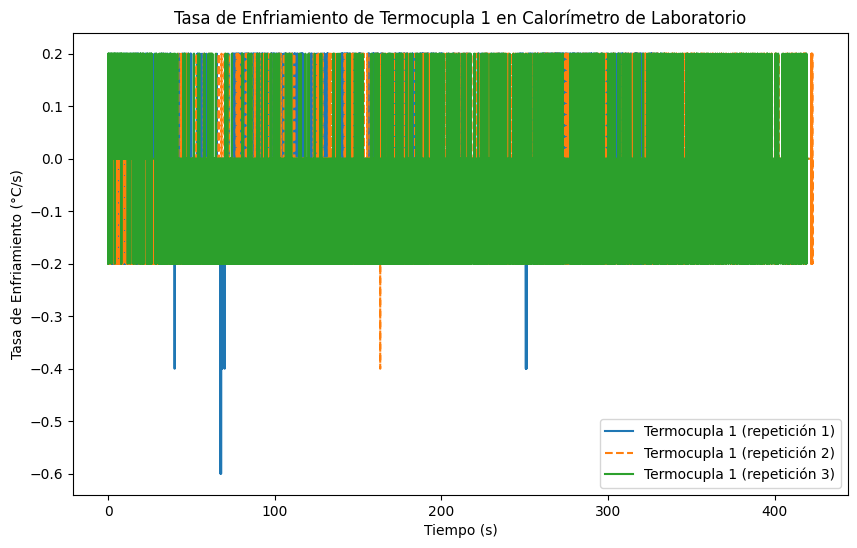

In [183]:
# Se calcula ahora la tasa de cambio de las mediciones hechas con la termocupla 1 a través de la gradiente de los datos.

# Calorímetro del laboratorio - termocupla 1

# Calcular la tasa de enfriamiento
d10['tasa_enfriamiento_1'] = d10['Termocupla_1'].diff() / d10['Tiempo'].diff()
d11['tasa_enfriamiento_2'] = d11['Termocupla_1'].diff() / d11['Tiempo'].diff()
d12['tasa_enfriamiento_3'] = d12['Termocupla_1'].diff() / d12['Tiempo'].diff()

# Graficar los datos obtenidos
plt.figure(figsize=(10, 6))
plt.plot(d10['Tiempo'], d10['tasa_enfriamiento_1'], label='Termocupla 1 (repetición 1)')
plt.plot(d11['Tiempo'], d11['tasa_enfriamiento_2'], label='Termocupla 1 (repetición 2)', linestyle='dashed')
plt.plot(d12['Tiempo'], d12['tasa_enfriamiento_3'], label='Termocupla 1 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento de Termocupla 1 en Calorímetro de Laboratorio')
plt.legend()

# Promedios de la tasa de enfriamiento de cada medición realizada
tasa_promedio_1 = round(d10['tasa_enfriamiento_1'].mean(),3)
tasa_promedio_2 = round(d11['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d12['tasa_enfriamiento_3'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 2]: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 3]: {tasa_promedio_3} °C/s'+'\n')


plt.show()

Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 1]: -0.005 °C/s
Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 2]: -0.02 °C/s
Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 3]: -0.01 °C/s

Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 1]: -0.005 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 2]: -0.02 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 3]: -0.01 °C/s



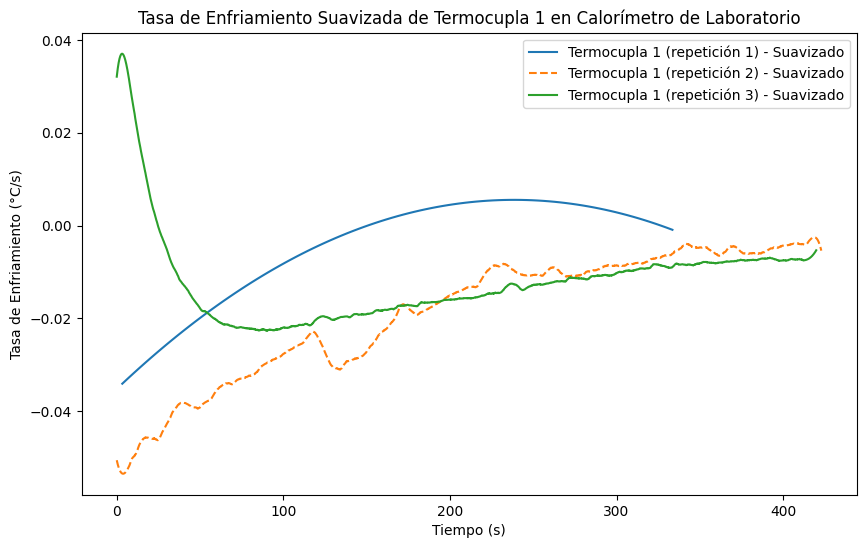

In [184]:
# Se aplica el filtrado uniforme 1-D y filtro de Savitzky-Golay para visualizar mejor el comportamiento y tendencia
# de la tasa de cambio para cada repetición.

#Calorímetro del laboratorio - termocupla 1

# Calcular la tasa de enfriamiento
df10_ip_t1['tasa_enfriamiento_1'] = df10_ip_t1['Termocupla_1'].diff() / df10_ip_t1['Tiempo'].diff()
d11['tasa_enfriamiento_2'] = d11['Termocupla_1'].diff() / d11['Tiempo'].diff()
d12['tasa_enfriamiento_3'] = d12['Termocupla_1'].diff() / d12['Tiempo'].diff()

df10_ip_t1.dropna(subset=['tasa_enfriamiento_1'], inplace=True)
d11.dropna(subset=['tasa_enfriamiento_2'], inplace=True)
d12.dropna(subset=['tasa_enfriamiento_3'], inplace=True)

# Suavizar los datos usando una media móvil
window_size = 300  # Ajusta este valor según sea necesario
poly_order = 3    # Orden del polinomio

df10_ip_t1['tasa_enfriamiento_1_suavizada'] = df10_ip_t1['tasa_enfriamiento_1']
d11['tasa_enfriamiento_2_suavizada'] = savgol_filter(uniform_filter1d(d11['tasa_enfriamiento_2'], size=50), window_size, poly_order)
d12['tasa_enfriamiento_3_suavizada'] = savgol_filter(uniform_filter1d(d12['tasa_enfriamiento_3'], size=50), window_size, poly_order)

# Graficar los datos suavizados
plt.figure(figsize=(10, 6))
plt.plot(df10_ip_t1['Tiempo'], df10_ip_t1['tasa_enfriamiento_1_suavizada'], label='Termocupla 1 (repetición 1) - Suavizado')
plt.plot(d11['Tiempo'], d11['tasa_enfriamiento_2_suavizada'], label='Termocupla 1 (repetición 2) - Suavizado', linestyle='dashed')
plt.plot(d12['Tiempo'], d12['tasa_enfriamiento_3_suavizada'], label='Termocupla 1 (repetición 3) - Suavizado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento Suavizada de Termocupla 1 en Calorímetro de Laboratorio')
plt.legend()

# Se comparab los promedios de tasa de enfriamiento de los datos originales y los uavizados.
tasa_promedio_1 = round(df10_ip_t1['tasa_enfriamiento_1'].mean(),3)
tasa_promedio_2 = round(d11['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d12['tasa_enfriamiento_3'].mean(),2)

tasa_promedio_1s = round(df10_ip_t1['tasa_enfriamiento_1_suavizada'].mean(),3)
tasa_promedio_2s = round(d11['tasa_enfriamiento_2_suavizada'].mean(),2)
tasa_promedio_3s = round(d12['tasa_enfriamiento_3_suavizada'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 2]: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [repetición 3]: {tasa_promedio_3} °C/s'+'\n')

print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 1]: {tasa_promedio_1s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 2]: {tasa_promedio_2s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [repetición 3]: {tasa_promedio_3s} °C/s'+'\n')

plt.show()

In [185]:
# La tasa de cambio es más regular en la repetición 1, en la repetición 2 no lo es tanto pero sin embargo muestra el enfriamiento de lo medido.
# Para la repetición 3 se ve que hay un calentamiento en la medición pero luego "suavemente" se va enfriando.

Tasa de enfriamiento promedio del Calorímetro casero [repetición 1]: -0.0 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [repetición 2]: -0.01 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [repetición 3]: -0.02 °C/s



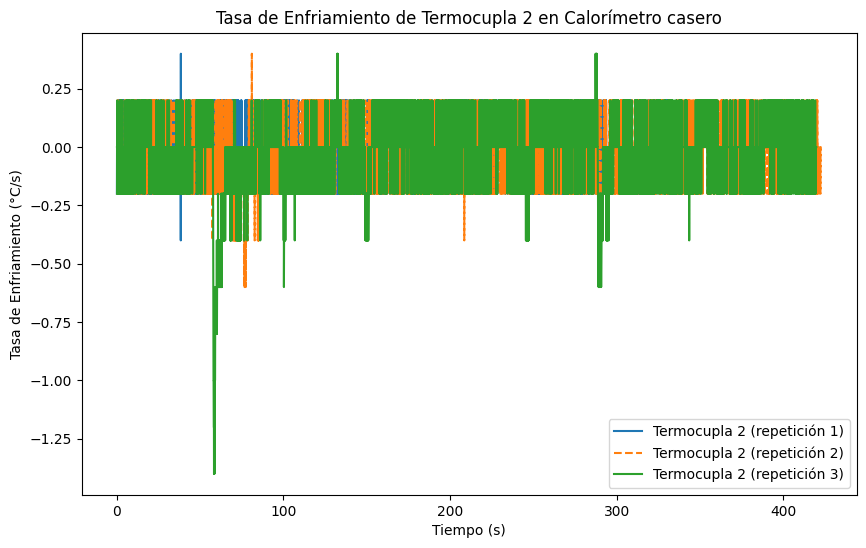

In [186]:
# Se obtiene la gradiente de las mediciones realizadas para calcular la tasa de enfriamiento presentada en cada
# repetición de la termocupla 2 en el calorímetro casero.
#Calorímetro casero - termocupla 2

# Calcular la tasa de enfriamiento
d10['tasa_enfriamiento_1'] = d10['Termocupla_2'].diff() / d10['Tiempo'].diff()
d11['tasa_enfriamiento_2'] = d11['Termocupla_2'].diff() / d11['Tiempo'].diff()
d12['tasa_enfriamiento_3'] = d12['Termocupla_2'].diff() / d12['Tiempo'].diff()

# Graficar los datos suavizados
plt.figure(figsize=(10, 6))
plt.plot(d10['Tiempo'], d10['tasa_enfriamiento_1'], label='Termocupla 2 (repetición 1)')
plt.plot(d11['Tiempo'], d11['tasa_enfriamiento_2'], label='Termocupla 2 (repetición 2)', linestyle='dashed')
plt.plot(d12['Tiempo'], d12['tasa_enfriamiento_3'], label='Termocupla 2 (repetición 3)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento de Termocupla 2 en Calorímetro casero')
plt.legend()

# Tasa de enfriamiento promedio de cada repetición
tasa_promedio_1 = round(d10['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d11['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(d12['tasa_enfriamiento_3'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 2]: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 3]: {tasa_promedio_3} °C/s'+'\n')

plt.show()

Tasa de enfriamiento promedio del Calorímetro casero [repetición 1]: -0.0 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [repetición 2]: -0.01 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [repetición 3]: -0.03 °C/s

Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 1]: -0.0 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 2]: -0.01 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 3]: -0.03 °C/s



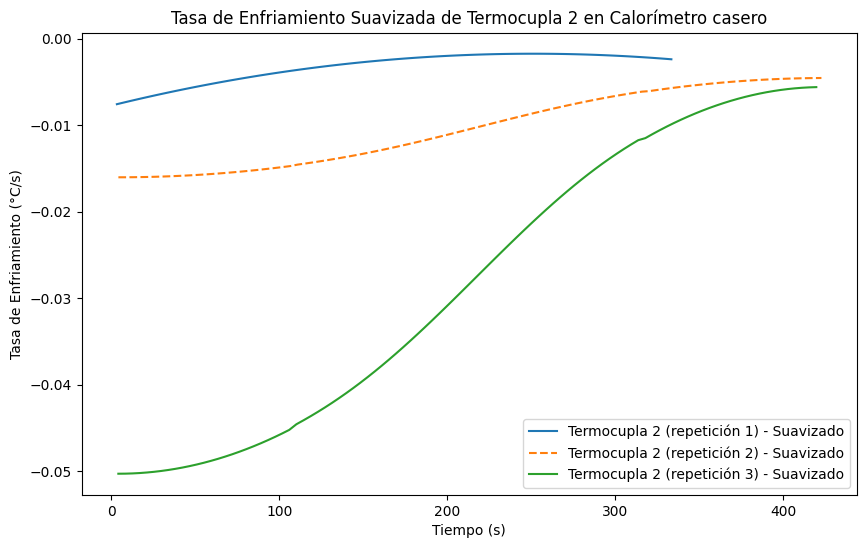

In [187]:
# Luego a través del filtro uniforme 1-D y el filtro de Savitzky-Golay se suavizan los datos y se muestra de
# forma clara el comportamiento de la tasa de cambio.
#Calorímetro casero - termocupla 2

# Calcular la tasa de enfriamiento
df10_ip_t2['tasa_enfriamiento_1'] = df10_ip_t2['Termocupla_2'].diff() / df10_ip_t2['Tiempo'].diff()
df11_ip_t2['tasa_enfriamiento_2'] = df11_ip_t2['Termocupla_2'].diff() / df11_ip_t2['Tiempo'].diff()
df12_ip_t2['tasa_enfriamiento_3'] = df12_ip_t2['Termocupla_2'].diff() / df12_ip_t2['Tiempo'].diff()

df10_ip_t2.dropna(subset=['tasa_enfriamiento_1'], inplace=True)
df11_ip_t2.dropna(subset=['tasa_enfriamiento_2'], inplace=True)
df12_ip_t2.dropna(subset=['tasa_enfriamiento_3'], inplace=True)

# Suavizar los datos usando una media móvil
window_size = 50  # Ajusta este valor según sea necesario
poly_order = 3    # Orden del polinomio

df10_ip_t2['tasa_enfriamiento_1_suavizada'] = df10_ip_t2['tasa_enfriamiento_1']
df11_ip_t2['tasa_enfriamiento_2_suavizada'] = savgol_filter(uniform_filter1d(df11_ip_t2['tasa_enfriamiento_2'], size=100), window_size, poly_order)
df12_ip_t2['tasa_enfriamiento_3_suavizada'] = savgol_filter(uniform_filter1d(df12_ip_t2['tasa_enfriamiento_3'], size=100), window_size, poly_order)

# Graficar los datos suavizados
plt.figure(figsize=(10, 6))
plt.plot(df10_ip_t2['Tiempo'], df10_ip_t2['tasa_enfriamiento_1_suavizada'], label='Termocupla 2 (repetición 1) - Suavizado')
plt.plot(df11_ip_t2['Tiempo'], df11_ip_t2['tasa_enfriamiento_2_suavizada'], label='Termocupla 2 (repetición 2) - Suavizado', linestyle='dashed')
plt.plot(df12_ip_t2['Tiempo'], df12_ip_t2['tasa_enfriamiento_3_suavizada'], label='Termocupla 2 (repetición 3) - Suavizado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento Suavizada de Termocupla 2 en Calorímetro casero')
plt.legend()

# Comparar las tasas promedios de los datos originales con los suavizados.

tasa_promedio_1 = round(df10_ip_t2['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(df11_ip_t2['tasa_enfriamiento_2'].mean(),2)
tasa_promedio_3 = round(df12_ip_t2['tasa_enfriamiento_3'].mean(),2)

tasa_promedio_1s = round(df10_ip_t2['tasa_enfriamiento_1_suavizada'].mean(),2)
tasa_promedio_2s = round(df11_ip_t2['tasa_enfriamiento_2_suavizada'].mean(),2)
tasa_promedio_3s = round(df12_ip_t2['tasa_enfriamiento_3_suavizada'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 2]: {tasa_promedio_2} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [repetición 3]: {tasa_promedio_3} °C/s'+'\n')

print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 1]: {tasa_promedio_1s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 2]: {tasa_promedio_2s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [repetición 3]: {tasa_promedio_3s} °C/s'+'\n')

plt.show()

In [188]:
# Las tasa de enfriamiento promedio de los datos originales y suavizados son altamente equivalentes.
# El comportamiento y tendencia originales de los datos se mantienen.

Parámetros del ajuste exponencial (repetición 1): a=2.23, b=0.03, c=4.89 => T = [2.23*e^(-0.03*t)]+4.89 || R^2=0.6671
Parámetros del ajuste exponencial (repetición 2): a=8.68, b=0.01, c=5.8 => T = [8.68*e^(-0.01*t)]+5.8 || R^2=0.9994
Parámetros del ajuste exponencial (repetición 3): a=10.16, b=0.0, c=2.04 => T = [10.16*e^(-0.0*t)]+2.04 || R^2=0.9898

Parámetros del ajuste exponencial promedios: a=7.02, b=0.01, c=4.24



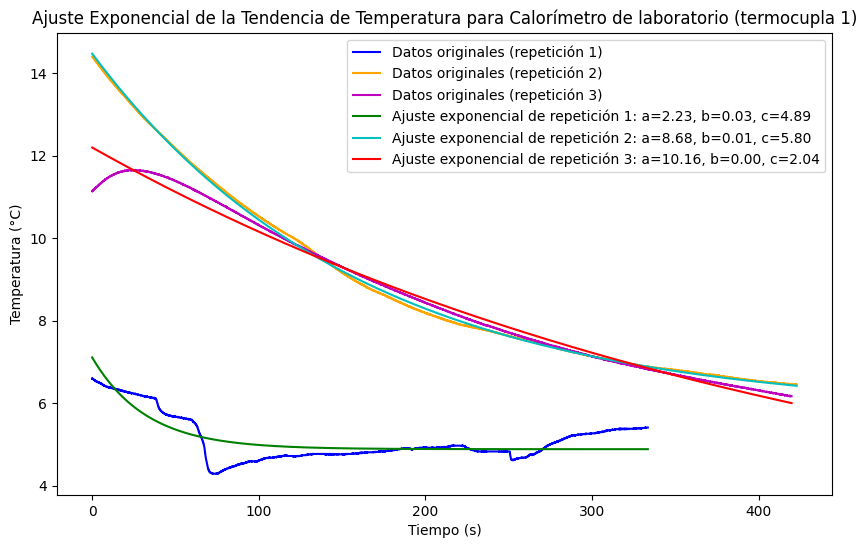

In [222]:
# Se realiza ajuste exponencial de los datos de la termocupla 1 con la ecuación mono-exponencial para obtener más información sobre su
# comportamiento, tendencia y realizar predicciones además de comprobar si los datos están dentro del comportamiento esperado.

# Calorímetro de laboratorio - termocupla 1
# Función exponencial
def monoExp(x, a, b, c):
    return a * np.exp(-b * x) + c

# Ajustar una curva exponencial a los datos

popt_10t1, pcov_10t1 = curve_fit(monoExp, d10['Tiempo'].dropna(), d10['Termocupla_1'].dropna())
popt_11t1, pcov_11t1 = curve_fit(monoExp, d11['Tiempo'].dropna(), d11['Termocupla_1'].dropna())
popt_12t1, pcov_12t1 = curve_fit(monoExp, d12['Tiempo'].dropna(), d12['Termocupla_1'].dropna())

# Generar datos para la curva ajustada
tiempo_fit_10t1 = np.linspace(d10['Tiempo'].min(), d10['Tiempo'].max(), 50000)
tasa_fit_10t1 = monoExp(tiempo_fit_10t1, *popt_10t1)

tiempo_fit_11t1 = np.linspace(d11['Tiempo'].min(), d11['Tiempo'].max(), 500)
tasa_fit_11t1 = monoExp(tiempo_fit_11t1, *popt_11t1)

tiempo_fit_12t1 = np.linspace(d12['Tiempo'].min(), d12['Tiempo'].max(), 500)
tasa_fit_12t1 = monoExp(tiempo_fit_12t1, *popt_12t1)

# Calcular R^2 para cada ajuste
R2_10t1 = calcular_R2(d10['Termocupla_1'].dropna(), monoExp(d10['Tiempo'].dropna(), *popt_10t1))
R2_11t1 = calcular_R2(d11['Termocupla_1'].dropna(), monoExp(d11['Tiempo'].dropna(), *popt_11t1))
R2_12t1 = calcular_R2(d12['Termocupla_1'].dropna(), monoExp(d12['Tiempo'].dropna(), *popt_12t1))


# Graficar los datos y la curva ajustada
plt.figure(figsize=(10, 6))
plt.plot(d10['Tiempo'], d10['Termocupla_1'], 'b-', label='Datos originales (repetición 1)')
plt.plot(d11['Tiempo'], d11['Termocupla_1'], 'orange', label='Datos originales (repetición 2)')
plt.plot(d12['Tiempo'], d12['Termocupla_1'], 'm-', label='Datos originales (repetición 3)')

plt.plot(tiempo_fit_10t1, tasa_fit_10t1, 'g-', label='Ajuste exponencial de repetición 1: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_10t1))
plt.plot(tiempo_fit_11t1, tasa_fit_11t1, 'c-', label='Ajuste exponencial de repetición 2: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_11t1))
plt.plot(tiempo_fit_12t1, tasa_fit_12t1, 'r-', label='Ajuste exponencial de repetición 3: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_12t1))

plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Ajuste Exponencial de la Tendencia de Temperatura para Calorímetro de laboratorio (termocupla 1)')
plt.legend()

print(f'Parámetros del ajuste exponencial (repetición 1): a={round(popt_10t1[0],2)}, b={round(popt_10t1[1],2)}, c={round(popt_10t1[2],2)} => T = [{round(popt_10t1[0],2)}*e^(-{round(popt_10t1[1],2)}*t)]+{round(popt_10t1[2],2)} || R^2={R2_10t1:.4f}')
print(f'Parámetros del ajuste exponencial (repetición 2): a={round(popt_11t1[0],2)}, b={round(popt_11t1[1],2)}, c={round(popt_11t1[2],2)} => T = [{round(popt_11t1[0],2)}*e^(-{round(popt_11t1[1],2)}*t)]+{round(popt_11t1[2],2)} || R^2={R2_11t1:.4f}')
print(f'Parámetros del ajuste exponencial (repetición 3): a={round(popt_12t1[0],2)}, b={round(popt_12t1[1],2)}, c={round(popt_12t1[2],2)} => T = [{round(popt_12t1[0],2)}*e^(-{round(popt_12t1[1],2)}*t)]+{round(popt_12t1[2],2)} || R^2={R2_12t1:.4f}')
print()

print(f'Parámetros del ajuste exponencial promedios: a={round((popt_10t1[0]+popt_11t1[0]+popt_12t1[0])/3,2)}, b={round((popt_10t1[1]+popt_11t1[1]+popt_12t1[1])/3,2)}, c={round((popt_10t1[2]+popt_11t1[2]+popt_12t1[2])/3,2)}')
print()
plt.show()

In [190]:
# Se observa que para los datos de la repeticiones 2 y 3, las funciones de ajuste explican casi el 100% de los datos (R^2).
# Sin embargo con la repeteción 1 debido a su irregularidad, solo se explica casi el 67% de los datos (R^2) pero se dibuja la
# tendencia de curva que tiene.

Parámetros del ajuste exponencial (repetición 1): a=1.19, b=0.01, c=0.92 => T = [1.19*e^(-0.01*t)]+0.92 || R^2=0.9170
Parámetros del ajuste exponencial (repetición 2): a=4.01, b=0.01, c=1.86 => T = [4.01*e^(-0.01*t)]+1.86 || R^2=0.8362
Parámetros del ajuste exponencial (repetición 3): a=11.31, b=0.01, c=1.36 => T = [11.31*e^(-0.01*t)]+1.36 || R^2=0.8966

Parámetros del ajuste exponencial promedios: a=5.5, b=0.01, c=1.38



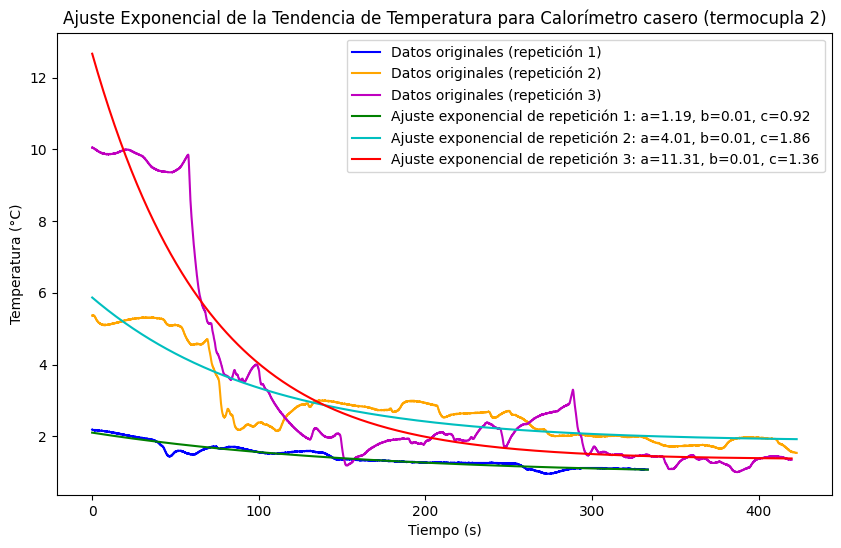

In [191]:
# Se busca a través de un ajuste exponencial a los datos obtenidos con la termocupla 2 las ecuaciones que se ajusten a estos y al mismo tiempo
# obtener información sobre las mediciones realizadas y la calidad de las mismas.

# Calorímetro casero - termocupla 2
# Función exponencial
def monoExp(x, a, b, c):
    return a * np.exp(-b * x) + c

# Ajustar una curva exponencial a los datos

popt_10t2, pcov_10t2 = curve_fit(monoExp, d10['Tiempo'].dropna(), d10['Termocupla_2'].dropna())
popt_11t2, pcov_11t2 = curve_fit(monoExp, d11['Tiempo'].dropna(), d11['Termocupla_2'].dropna())
popt_12t2, pcov_12t2 = curve_fit(monoExp, d12['Tiempo'].dropna(), d12['Termocupla_2'].dropna())

# Generar datos para la curva ajustada
tiempo_fit_10t2 = np.linspace(d10['Tiempo'].min(), d10['Tiempo'].max(), 50000)
tasa_fit_10t2 = monoExp(tiempo_fit_10t2, *popt_10t2)

tiempo_fit_11t2 = np.linspace(d11['Tiempo'].min(), d11['Tiempo'].max(), 500)
tasa_fit_11t2 = monoExp(tiempo_fit_11t2, *popt_11t2)

tiempo_fit_12t2 = np.linspace(d12['Tiempo'].min(), d12['Tiempo'].max(), 500)
tasa_fit_12t2 = monoExp(tiempo_fit_12t2, *popt_12t2)

# Calcular R^2 para cada ajuste
R2_10t2 = calcular_R2(d10['Termocupla_2'].dropna(), monoExp(d10['Tiempo'].dropna(), *popt_10t2))
R2_11t2 = calcular_R2(d11['Termocupla_2'].dropna(), monoExp(d11['Tiempo'].dropna(), *popt_11t2))
R2_12t2 = calcular_R2(d12['Termocupla_2'].dropna(), monoExp(d12['Tiempo'].dropna(), *popt_12t2))


# Graficar los datos y la curva ajustada
plt.figure(figsize=(10, 6))
plt.plot(d10['Tiempo'], d10['Termocupla_2'], 'b-', label='Datos originales (repetición 1)')
plt.plot(d11['Tiempo'], d11['Termocupla_2'], 'orange', label='Datos originales (repetición 2)')
plt.plot(d12['Tiempo'], d12['Termocupla_2'], 'm-', label='Datos originales (repetición 3)')

plt.plot(tiempo_fit_10t2, tasa_fit_10t2, 'g-', label='Ajuste exponencial de repetición 1: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_10t2))
plt.plot(tiempo_fit_11t2, tasa_fit_11t2, 'c-', label='Ajuste exponencial de repetición 2: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_11t2))
plt.plot(tiempo_fit_12t2, tasa_fit_12t2, 'r-', label='Ajuste exponencial de repetición 3: a=%.2f, b=%.2f, c=%.2f' % tuple(popt_12t2))

plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Ajuste Exponencial de la Tendencia de Temperatura para Calorímetro casero (termocupla 2)')
plt.legend()

print(f'Parámetros del ajuste exponencial (repetición 1): a={round(popt_10t2[0],2)}, b={round(popt_10t2[1],2)}, c={round(popt_10t2[2],2)} => T = [{round(popt_10t2[0],2)}*e^(-{round(popt_10t2[1],2)}*t)]+{round(popt_10t2[2],2)} || R^2={R2_10t2:.4f}')
print(f'Parámetros del ajuste exponencial (repetición 2): a={round(popt_11t2[0],2)}, b={round(popt_11t2[1],2)}, c={round(popt_11t2[2],2)} => T = [{round(popt_11t2[0],2)}*e^(-{round(popt_11t2[1],2)}*t)]+{round(popt_11t2[2],2)} || R^2={R2_11t2:.4f}')
print(f'Parámetros del ajuste exponencial (repetición 3): a={round(popt_12t2[0],2)}, b={round(popt_12t2[1],2)}, c={round(popt_12t2[2],2)} => T = [{round(popt_12t2[0],2)}*e^(-{round(popt_12t2[1],2)}*t)]+{round(popt_12t2[2],2)} || R^2={R2_12t2:.4f}')
print()

print(f'Parámetros del ajuste exponencial promedios: a={round((popt_10t2[0]+popt_11t2[0]+popt_12t2[0])/3,2)}, b={round((popt_10t2[1]+popt_11t2[1]+popt_12t2[1])/3,2)}, c={round((popt_10t2[2]+popt_11t2[2]+popt_12t2[2])/3,2)}')
print()
plt.show()

In [192]:
# Como todas las repeticiones con la termocupla 2 presentan un comportamiento de cierta irregularidad, las ecuaciones de ajuste obtenidas no llegan
# a explicar todos los datos sin embargo sí que traza el sentido que tienen los datos que es una curva.

Combinación de cada conjunto de datos de repeticiones, a través de una promediación entre estos, con ayuda de una interpolación lineal para partes faltantes; para cada calorímetro respectivo.

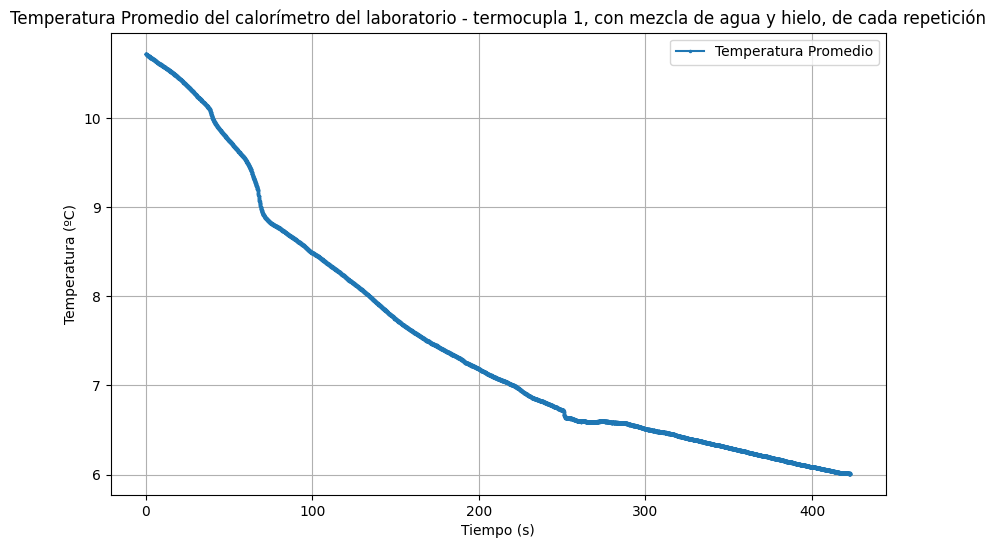

In [193]:
# Combinación de datos del calorímetro del laboratorio

# Crear una referencia de tiempo común usando la intersección de los rangos de tiempo de cada DataFrame
tiempo_comun = pd.Series(sorted(set(d10['Tiempo']).union(set(d11['Tiempo'])).union(set(d12['Tiempo']))))

# Interpolación para alinear los datos
d10_interp = d10.set_index('Tiempo').reindex(tiempo_comun).interpolate(method='linear').reset_index()
d11_interp = d11.set_index('Tiempo').reindex(tiempo_comun).interpolate(method='linear').reset_index()
d12_interp = d12.set_index('Tiempo').reindex(tiempo_comun).interpolate(method='linear').reset_index()

# Crear un DataFrame para las mediciones promedio
df_combinadot1 = pd.DataFrame()

# Asignar la columna 'Tiempo'
df_combinadot1['Tiempo'] = tiempo_comun

# Calcular el promedio de las columnas de temperatura
df_combinadot1['Temperatura_Promedio'] = (d10_interp['Termocupla_1'] + d11_interp['Termocupla_1'] + d12_interp['Termocupla_1']) / 3

plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Graficar la temperatura promedio
plt.plot(df_combinadot1['Tiempo'], df_combinadot1['Temperatura_Promedio'], label='Temperatura Promedio', marker='o', linestyle='-', markersize=1.5)

# Configurar etiquetas y título
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (ºC)')
plt.title('Temperatura Promedio del calorímetro del laboratorio - termocupla 1, con mezcla de agua y hielo, de cada repetición')
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.grid(True)  # Mostrar cuadrícula
plt.show()

In [194]:
# Es el promedio de todas las repeticiones de las mediciones de la mezcla de agua con hielo hechas por la termocupla 1 en el calorímetro de laboratorio.

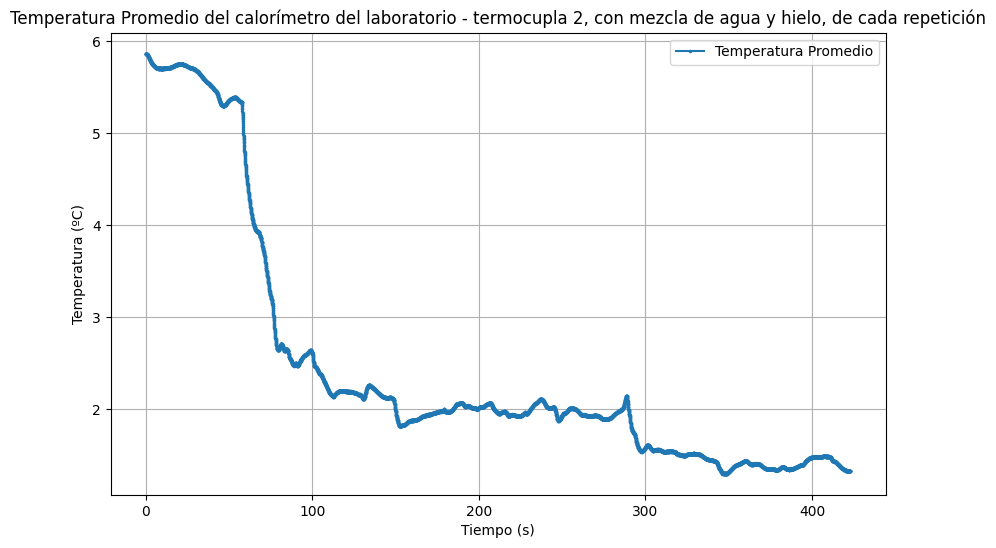

In [195]:
# Combinación de datos del calorímetro del laboratorio

# Crear una referencia de tiempo común usando la intersección de los rangos de tiempo de cada DataFrame
tiempo_comun = pd.Series(sorted(set(d10['Tiempo']).union(set(d11['Tiempo'])).union(set(d12['Tiempo']))))

# Interpolación para alinear los datos
d10_interp = d10.set_index('Tiempo').reindex(tiempo_comun).interpolate(method='linear').reset_index()
d11_interp = d11.set_index('Tiempo').reindex(tiempo_comun).interpolate(method='linear').reset_index()
d12_interp = d12.set_index('Tiempo').reindex(tiempo_comun).interpolate(method='linear').reset_index()

# Crear un DataFrame para las mediciones promedio
df_combinadot2 = pd.DataFrame()

# Asignar la columna 'Tiempo'
df_combinadot2['Tiempo'] = tiempo_comun

# Calcular el promedio de las columnas de temperatura
df_combinadot2['Temperatura_Promedio'] = (d10_interp['Termocupla_2'] + d11_interp['Termocupla_2'] + d12_interp['Termocupla_2']) / 3

plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Graficar la temperatura promedio
plt.plot(df_combinadot2['Tiempo'], df_combinadot2['Temperatura_Promedio'], label='Temperatura Promedio', marker='o', linestyle='-', markersize=1.5)

# Configurar etiquetas y título
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (ºC)')
plt.title('Temperatura Promedio del calorímetro del laboratorio - termocupla 2, con mezcla de agua y hielo, de cada repetición')
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.grid(True)  # Mostrar cuadrícula
plt.show()

In [196]:
# Es el promedio de todas las repeticiones de las mediciones de la mezcla de agua con hielo hechas por la termocupla 2 en el calorímetro casero.

Prueba Pearson de correlación de datos de temperatura entre los calorímetros de laboratorio y casero.

In [197]:
corr_coef, p_value = stats.pearsonr(df_combinadot1['Temperatura_Promedio'].dropna(), df_combinadot2['Temperatura_Promedio'].dropna())

# Mostrar resultados
print(f"Coeficiente de correlación de Pearson: {corr_coef}")
print(f"Valor p: {p_value}")

# Interpretación del resultado
if p_value < alpha:
    print("Existe una correlación significativa entre los datos.")
else:
    print("No hay suficiente evidencia para afirmar una correlación significativa entre los datos.")

Coeficiente de correlación de Pearson: 0.9330230268992409
Valor p: 0.0
Existe una correlación significativa entre los datos.


**Cálculo del calor absorvido del agua con hielo, entre calorímetros**

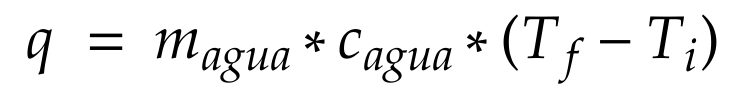

In [198]:
print("Calor absorvido por calorímetros: ")
m_agua = 126.1 #g // Masa de agua utilizada para cada repetición

# Para calorimetro de laboratorio - termocupla 1
m_hielo_lab = round((106.4+100+100.4)/3,2) #g // Promedio de masa de las muestras de hielo
m = m_hielo_lab+m_agua # masa total de la mezcla de agua con hielo
c = 4.18 #J/g*ºC // calor específico del agua
q_cl = round(m*c*(df_combinadot1['Temperatura_Promedio'].max()-df_combinadot1['Temperatura_Promedio'].min()),2)
print('Calorímetro de laboratorio (termocupla 1):',q_cl,'J')

# Para calorimeto casero - termocupla 2
m_hielo_lab = round((100.4+101.3+114.6)/3,2) #g // Promedio de masa de las muestras de hielo
m = m_hielo_lab+m_agua # masa total de la mezcla de agua con hielo
q_cs = round(m*c*(df_combinadot2['Temperatura_Promedio'].max()-df_combinadot2['Temperatura_Promedio'].min()),2)
print('Calorímetro casero (termocupla 2):', q_cs,'J')

Calor absorvido por calorímetros: 
Calorímetro de laboratorio (termocupla 1): 4496.1 J
Calorímetro casero (termocupla 2): 4422.82 J


# Sección 2. Mezcla de agua y bloque de metal

In [199]:
# Se acceden a los datos de los que se tomaron las temperaturas de los bloques de metal
f13 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteB/temp1_bloques_metal.csv'

d13 = pd.read_csv(f13)

Diferencias promedios de la temperatura inicial medida de los bloques:
· bloque 1 con bloque 2: 0.48 ºC



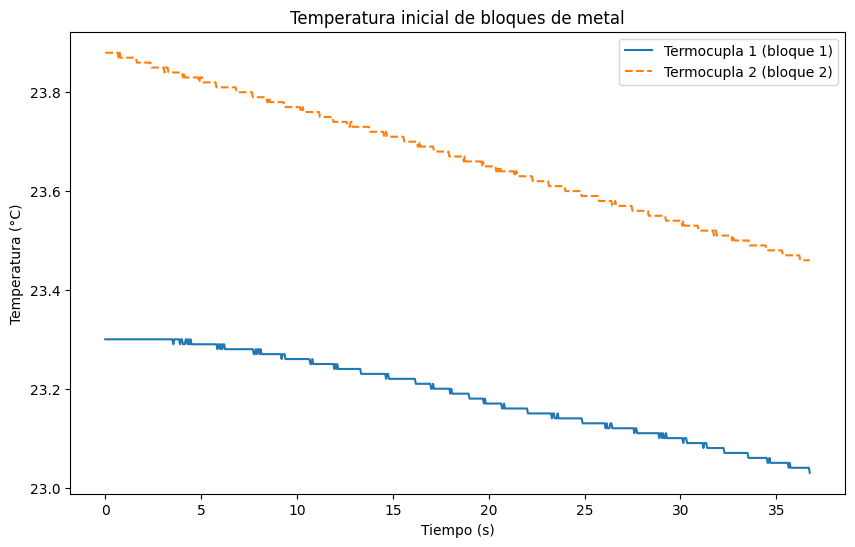

In [200]:
# Se organizan los datos de temperatura
plt.figure(figsize=(10, 6))
plt.plot(d13['Tiempo'], d13['Termocupla_1'], label='Termocupla 1 (bloque 1)')
plt.plot(d13['Tiempo'], d13['Termocupla_2'], label='Termocupla 2 (bloque 2)', linestyle='dashed')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura inicial de bloques de metal')
plt.legend()

print("Diferencias promedios de la temperatura inicial medida de los bloques:")
difd13_t1_t2 = round(abs(np.mean([d13['Termocupla_1']]) - np.mean([d13['Termocupla_2']])),2)
print('· bloque 1 con bloque 2: '+str(difd13_t1_t2)+' ºC'+'\n')

plt.show()


In [201]:
# Es una diferencia de temperatura mínima pero puede deberse al calentamiento de donde estuvieron los bloques y lo que hayan medido anteriormente
# las termocuplas.

Análisis de varianza (ANOVA) de la temperatura inicial medida de los bloques

Estadístico F: 7805.1695284196485
Valor p: 0.0
Hay diferencias significativas entre al menos dos grupos.



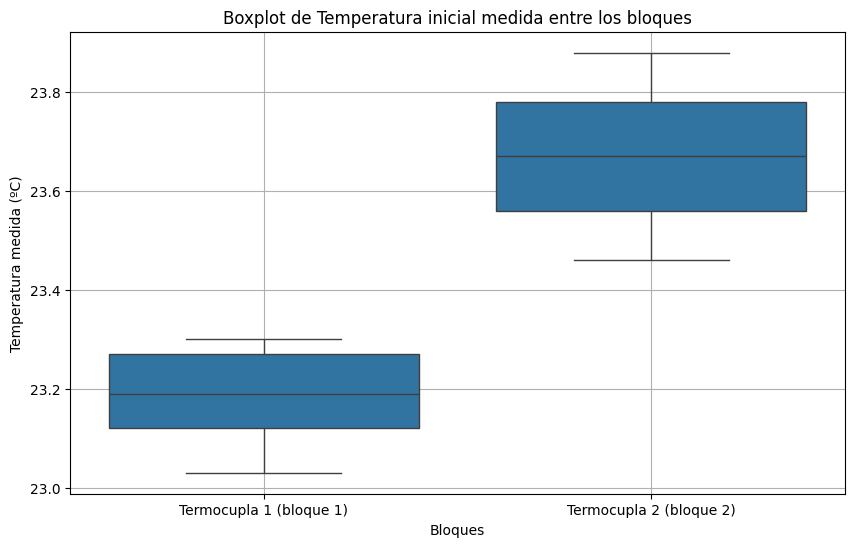

In [202]:
# Aplicación de ANOVA para verificar la varianza existente entre las mediciones de temperatura de ambos bloques.

df = pd.DataFrame({
    'Bloque': ['Termocupla 1 (bloque 1)'] * len(d13['Termocupla_1']) + ['Termocupla 2 (bloque 2)'] * len(d13['Termocupla_2']),
    'Temperatura de los bloques (ºC)': pd.concat([d13['Termocupla_1'], d13['Termocupla_2']])
})

# Graficar boxplots para comprensión gráfica de la varianza y distribución de los datos.
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bloque', y='Temperatura de los bloques (ºC)', data=df)
plt.title('Boxplot de Temperatura inicial medida entre los bloques')
plt.xlabel('Bloques')
plt.ylabel('Temperatura medida (ºC)')
plt.grid(True)


# Aplicar ANOVA
statistic, p_value = f_oneway(d13['Termocupla_1'], d13['Termocupla_2'])

# Mostrar resultados
print('Análisis de varianza (ANOVA) de la temperatura inicial medida de los bloques\n')
print(f'Estadístico F: {statistic}')
print(f'Valor p: {p_value}')

# Interpretación del resultado
alpha = 0.05
if p_value < alpha:
    print('Hay diferencias significativas entre al menos dos grupos.')
else:
    print('No hay evidencia suficiente para afirmar diferencias significativas entre los grupos.')
print()
plt.show()

In [203]:
# Además de que el rango entre los valores es distinto en cada serie de datos, también la media es distinta y existe lejanía entre los datos.

In [204]:
# Iniciación de las temperaturas del agua destilada destinadas a los calorímetros.

f14 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteB/temp3_agua_destilada_calorimetro_serio_termocupla1.csv'
f15 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteB/temp2_agua_destilada_calorimetro_casero_termocupla2.csv'

d14 = pd.read_csv(f14)
d15 = pd.read_csv(f15)

Diferencias promedios de la temperatura inicial medida de agua destilada:
· medición 1 con medición 2: 1.77 ºC



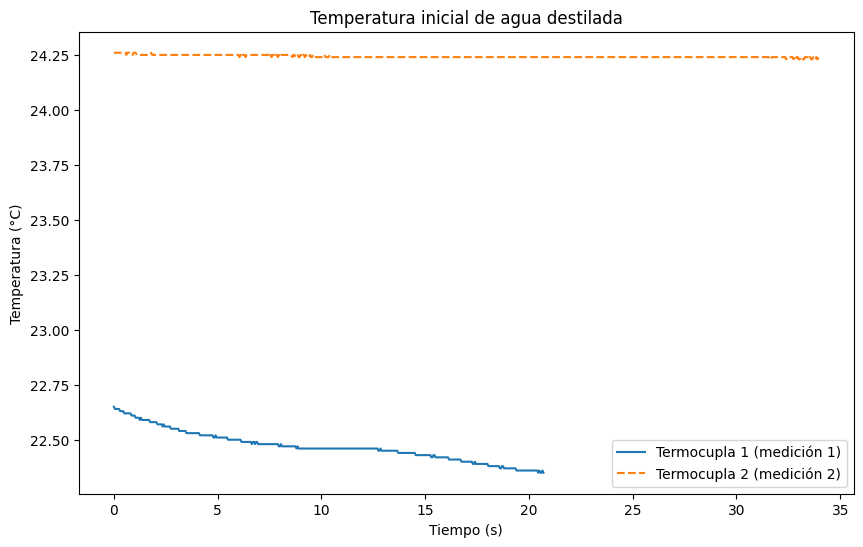

In [205]:
# Datos organizados para ser graficados
plt.figure(figsize=(10, 6))
plt.plot(d14['Tiempo'], d14['Termocupla_1'], label='Termocupla 1 (medición 1)')
plt.plot(d15['Tiempo'], d15['Termocupla_2'], label='Termocupla 2 (medición 2)', linestyle='dashed')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura inicial de agua destilada')
plt.legend()

print("Diferencias promedios de la temperatura inicial medida de agua destilada:")
dif_d14_d15 = round(abs(np.mean([d14['Termocupla_1']]) - np.mean([d15['Termocupla_2']])),2)
print('· medición 1 con medición 2: '+str(dif_d14_d15)+' ºC'+'\n')

plt.show()


Análisis de varianza (ANOVA) de la temperatura inicial medida entre las muestras de agua destilada 

Estadístico F: 437231.92908793484
Valor p: 0.0
Hay diferencias significativas entre al menos dos grupos.



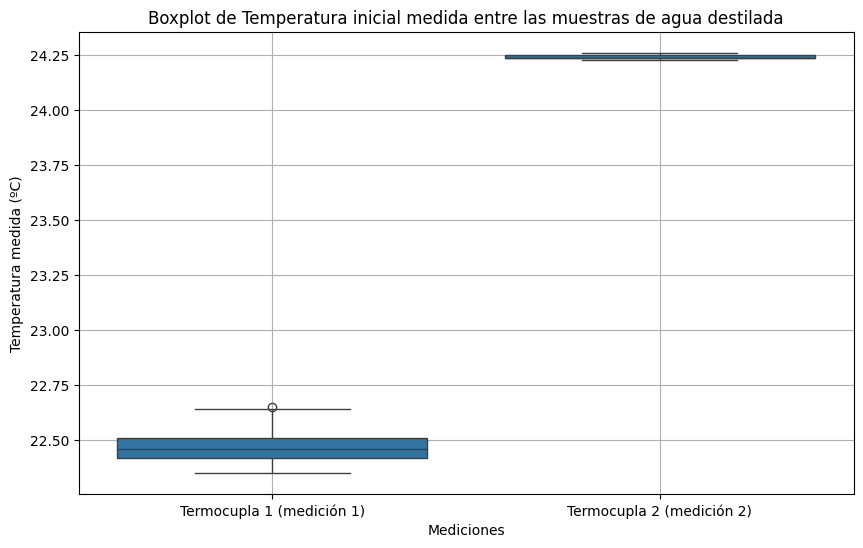

In [206]:
# Uso de ANOVA para obtener información sobre la varianza de los datos.

df = pd.DataFrame({
    'Mediciones': ['Termocupla 1 (medición 1)'] * len(d14['Termocupla_1']) + ['Termocupla 2 (medición 2)'] * len(d15['Termocupla_2']),
    'Temperatura del agua destilada (ºC)': pd.concat([d14['Termocupla_1'], d15['Termocupla_2']])
})

# Graficar boxplots para ver gráficamente la varianza entre los datos.
plt.figure(figsize=(10, 6))
sns.boxplot(x='Mediciones', y='Temperatura del agua destilada (ºC)', data=df)
plt.title('Boxplot de Temperatura inicial medida entre las muestras de agua destilada')
plt.xlabel('Mediciones')
plt.ylabel('Temperatura medida (ºC)')
plt.grid(True)


# Aplicar ANOVA
statistic, p_value = f_oneway(d14['Termocupla_1'], d15['Termocupla_2'])

# Mostrar resultados
print('Análisis de varianza (ANOVA) de la temperatura inicial medida entre las muestras de agua destilada \n')
print(f'Estadístico F: {statistic}')
print(f'Valor p: {p_value}')

# Interpretación del resultado
alpha = 0.05
if p_value < alpha:
    print('Hay diferencias significativas entre al menos dos grupos.')
else:
    print('No hay evidencia suficiente para afirmar diferencias significativas entre los grupos.')
print()
plt.show()

In [207]:
# Mediciones de la temperatura inicial de los bloques de metal
f16 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteB/temp4_metal1_calorimetro_pro.csv'
f17 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteB/temp5_metal2_calorimetro_casero.csv'

d16 = pd.read_csv(f16)
d17 = pd.read_csv(f17)

Diferencias promedios de las temperaturas de los bloques de metal:
· medición 1 con medición 2: 6.09 ºC



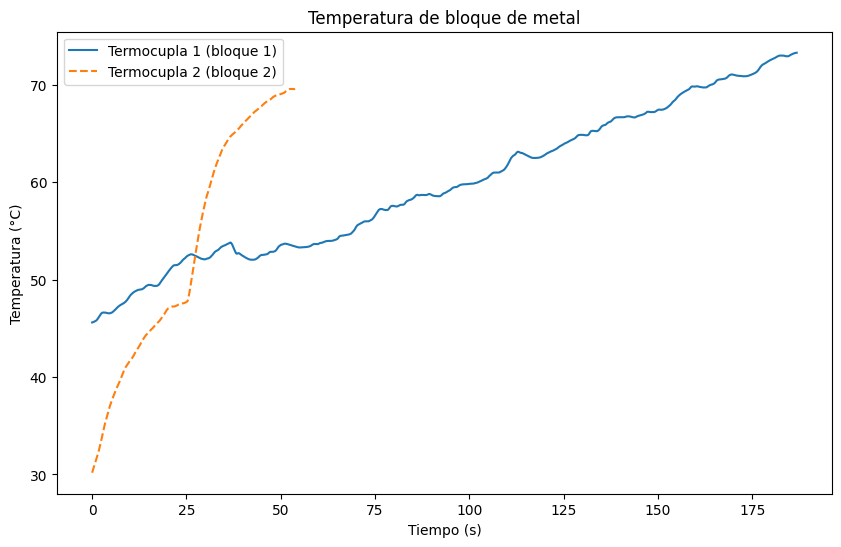

In [208]:
# Graficación de los datos
plt.figure(figsize=(10, 6))
plt.plot(d16['Tiempo'], d16['Termocupla_1'], label='Termocupla 1 (bloque 1)')
plt.plot(d17['Tiempo'], d17['Termocupla_2'], label='Termocupla 2 (bloque 2)', linestyle='dashed')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura de bloque de metal')
plt.legend()

print("Diferencias promedios de las temperaturas de los bloques de metal:")
dif_d16_d17 = round(abs(np.mean([d16['Termocupla_1']]) - np.mean([d17['Termocupla_2']])),2)
print('· medición 1 con medición 2: '+str(dif_d16_d17)+' ºC'+'\n')

plt.show()


Análisis de varianza (ANOVA) de la temperatura medida entre los bloques de metal

Estadístico F: 396.43666432426465
Valor p: 7.889764984504031e-85
Hay diferencias significativas entre al menos dos grupos.



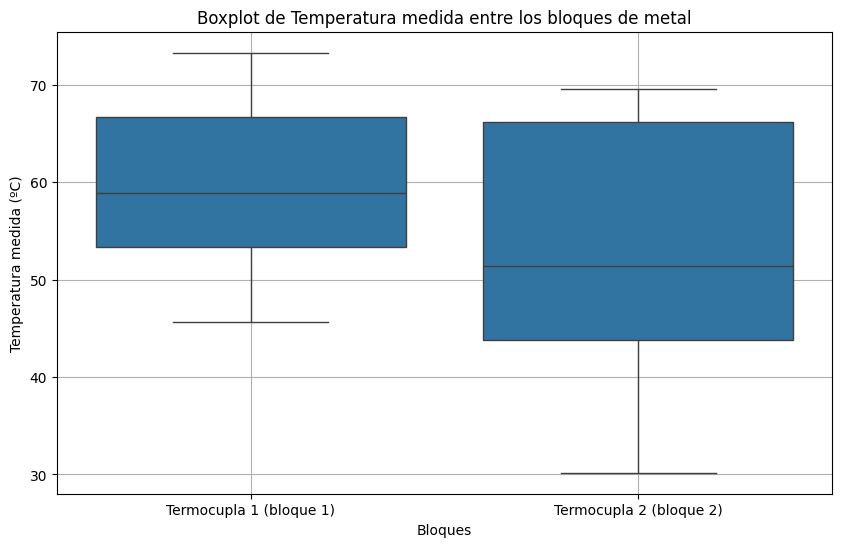

In [209]:
# Aplicar ANOVA para interpretación de la varianza existente entre los datos

df = pd.DataFrame({
    'Bloque': ['Termocupla 1 (bloque 1)'] * len(d16['Termocupla_1']) + ['Termocupla 2 (bloque 2)'] * len(d17['Termocupla_2']),
    'Temperatura de los bloques (ºC)': pd.concat([d16['Termocupla_1'], d17['Termocupla_2']])
})

# Graficar boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Bloque', y='Temperatura de los bloques (ºC)', data=df)
plt.title('Boxplot de Temperatura medida entre los bloques de metal')
plt.xlabel('Bloques')
plt.ylabel('Temperatura medida (ºC)')
plt.grid(True)


# Aplicar ANOVA
statistic, p_value = f_oneway(d16['Termocupla_1'], d17['Termocupla_2'])

# Mostrar resultados
print('Análisis de varianza (ANOVA) de la temperatura medida entre los bloques de metal\n')
print(f'Estadístico F: {statistic}')
print(f'Valor p: {p_value}')

# Interpretación del resultado
alpha = 0.05
if p_value < alpha:
    print('Hay diferencias significativas entre al menos dos grupos.')
else:
    print('No hay evidencia suficiente para afirmar diferencias significativas entre los grupos.')
print()
plt.show()

In [210]:
# Están cercanos los valores sin embargo existe varianza entre ellos.

In [211]:
# Mediciones de la temperatura del agua con bloque de metal.
f18 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteB/temp6_agua_metal_calorimetro_pro.csv'
f19 = '/content/drive/MyDrive/GoogleColab/Termo/Lab2/Datos/ParteB/temp7_agua_metal_calorimetro_casero.csv'

d18 = pd.read_csv(f18)
d19 = pd.read_csv(f19)

Diferencias promedios de la temperatura final de agua con metal:
· calorímetro de laboratorio con calorímetro casero: 9.75 ºC



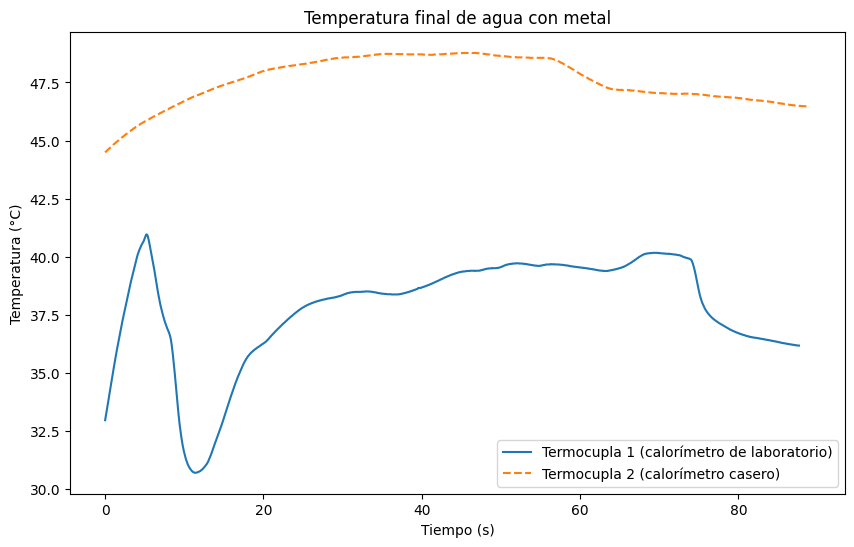

In [212]:
# Graficación de las temperaturas obtenidas del agua con el bloque de metal
plt.figure(figsize=(10, 6))
plt.plot(d18['Tiempo'], d18['Termocupla_1'], label='Termocupla 1 (calorímetro de laboratorio)')
plt.plot(d19['Tiempo'], d19['Termocupla_2'], label='Termocupla 2 (calorímetro casero)', linestyle='dashed')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura final de agua con metal')
plt.legend()

print("Diferencias promedios de la temperatura final de agua con metal:")
dif_d18_d19x = round(abs(np.mean([d18['Termocupla_1']]) - np.mean([d19['Termocupla_2']])),2)
print('· calorímetro de laboratorio con calorímetro casero: '+str(dif_d18_d19x)+' ºC'+'\n')
plt.show()

In [213]:
# Se eliminan los datoshasta antes de 40 segundos debido a que anterior a ese momento del tiempo, los medidores habian sido recientemente colocados.
indices_1, indices_2 = np.where(d18['Tiempo'] == 40)[0][0], np.where(d19['Tiempo'] == 40)[0][0]
print(indices_1, indices_2)
d18.drop(d18.index[0:indices_1], inplace=True)
d19.drop(d19.index[0:indices_2], inplace=True)

800 800


Diferencias promedios de la temperatura final de agua con metal:
· calorímetro de laboratorio con calorímetro casero: 8.8 ºC



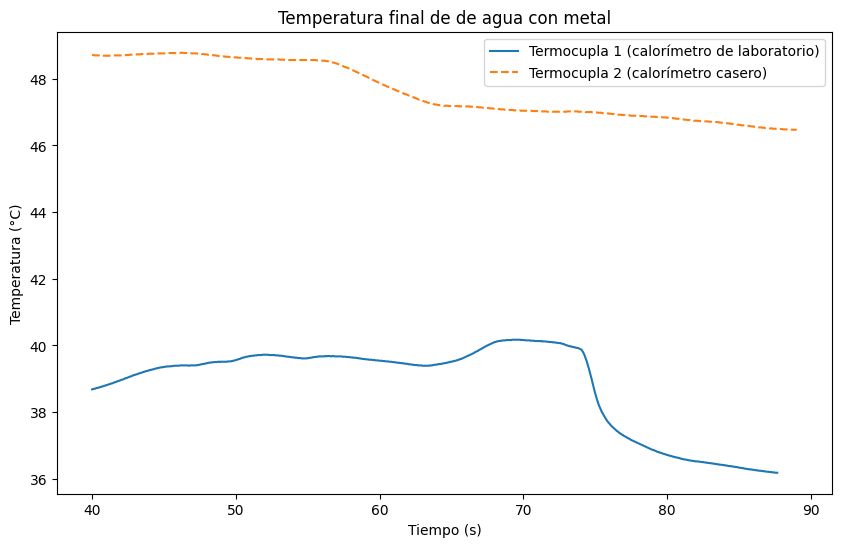

In [214]:
# Graficación del cambio
plt.figure(figsize=(10, 6))
plt.plot(d18['Tiempo'], d18['Termocupla_1'], label='Termocupla 1 (calorímetro de laboratorio)')
plt.plot(d19['Tiempo'], d19['Termocupla_2'], label='Termocupla 2 (calorímetro casero)', linestyle='dashed')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura final de de agua con metal')
plt.legend()

print("Diferencias promedios de la temperatura final de agua con metal:")
dif_d18_d19x = round(abs(np.mean([d18['Termocupla_1']]) - np.mean([d19['Termocupla_2']])),2)
print('· calorímetro de laboratorio con calorímetro casero: '+str(dif_d18_d19x)+' ºC'+'\n')
plt.show()

Tasa de enfriamiento promedio del Calorímetro de laboratorio [termocupla 1]: -0.05 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [termocupla 2]: -0.05 °C/s



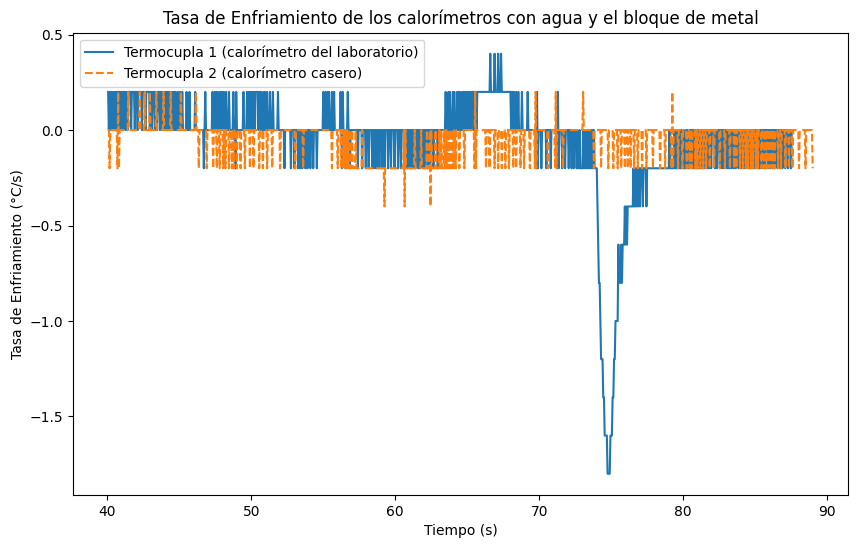

In [215]:
# Gradiente para obtener la tasa de enfriamiento de ambos calorímetros.
# Calcular la tasa de enfriamiento
d18['tasa_enfriamiento_1'] = d18['Termocupla_1'].diff() / d18['Tiempo'].diff()
d19['tasa_enfriamiento_2'] = d19['Termocupla_2'].diff() / d19['Tiempo'].diff()

# Graficar los datos suavizados
plt.figure(figsize=(10, 6))
plt.plot(d18['Tiempo'], d18['tasa_enfriamiento_1'], label='Termocupla 1 (calorímetro del laboratorio)')
plt.plot(d19['Tiempo'], d19['tasa_enfriamiento_2'], label='Termocupla 2 (calorímetro casero)', linestyle='dashed')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento de los calorímetros con agua y el bloque de metal')
plt.legend()

# Tasa de enfriamiento promedio de cada termocupla en sus calorímetros.
tasa_promedio_1 = round(d18['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d19['tasa_enfriamiento_2'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [termocupla 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [termocupla 2]: {tasa_promedio_2} °C/s'+'\n')
plt.show()

Tasa de enfriamiento promedio del Calorímetro de laboratorio [termocupla 1]: -0.05 °C/s
Tasa de enfriamiento promedio del Calorímetro casero [termocupla 2]: -0.05 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [termocupla 1]: -0.05 °C/s
Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [termocupla 2]: -0.05 °C/s



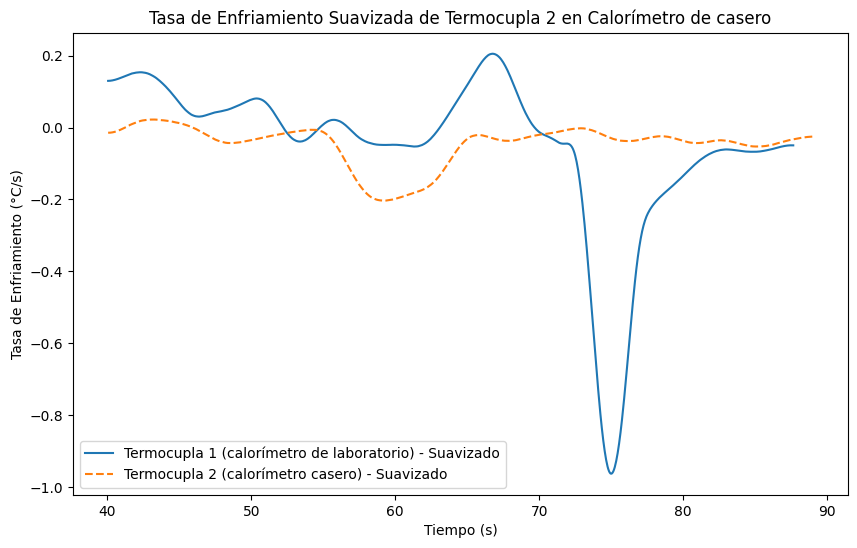

In [216]:
# Suavización de la tasa de cambio para observar de forma clara el comportamiento de estas usando filtrado uniforme 1-D y
# filtro de Savitzky-Golay

d18['tasa_enfriamiento_1'] = d18['Termocupla_1'].diff() / d18['Tiempo'].diff()
d19['tasa_enfriamiento_2'] = d19['Termocupla_2'].diff() / d19['Tiempo'].diff()

d18.dropna(subset=['tasa_enfriamiento_1'], inplace=True)
d19.dropna(subset=['tasa_enfriamiento_2'], inplace=True)

# Suavizar los datos usando una media móvil
window_size = 60  # Ajusta este valor según sea necesario
poly_order = 3    # Orden del polinomio

d18['tasa_enfriamiento_1_suavizada'] = savgol_filter(uniform_filter1d(d18['tasa_enfriamiento_1'], size=50), window_size, poly_order)
d19['tasa_enfriamiento_2_suavizada'] = savgol_filter(uniform_filter1d(d19['tasa_enfriamiento_2'], size=50), window_size, poly_order)

# Graficar los datos suavizados

plt.figure(figsize=(10, 6))
plt.plot(d18['Tiempo'], d18['tasa_enfriamiento_1_suavizada'], label='Termocupla 1 (calorímetro de laboratorio) - Suavizado')
plt.plot(d19['Tiempo'], d19['tasa_enfriamiento_2_suavizada'], label='Termocupla 2 (calorímetro casero) - Suavizado', linestyle='dashed')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Enfriamiento (°C/s)')
plt.title('Tasa de Enfriamiento Suavizada de Termocupla 2 en Calorímetro de casero')
plt.legend()

# Comparación de los valores promedio de tasa de enfriamiento entre los datos originales y los suavizados.
tasa_promedio_1 = round(d18['tasa_enfriamiento_1'].mean(),2)
tasa_promedio_2 = round(d19['tasa_enfriamiento_2'].mean(),2)

tasa_promedio_1s = round(d18['tasa_enfriamiento_1_suavizada'].mean(),2)
tasa_promedio_2s = round(d19['tasa_enfriamiento_2_suavizada'].mean(),2)

print(f'Tasa de enfriamiento promedio del Calorímetro de laboratorio [termocupla 1]: {tasa_promedio_1} °C/s')
print(f'Tasa de enfriamiento promedio del Calorímetro casero [termocupla 2]: {tasa_promedio_2} °C/s')

print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro de laboratorio [termocupla 1]: {tasa_promedio_1s} °C/s')
print(f'Tasa de enfriamiento promedio (suavizado) del Calorímetro casero [termocupla 2]: {tasa_promedio_2s} °C/s'+'\n')

plt.show()


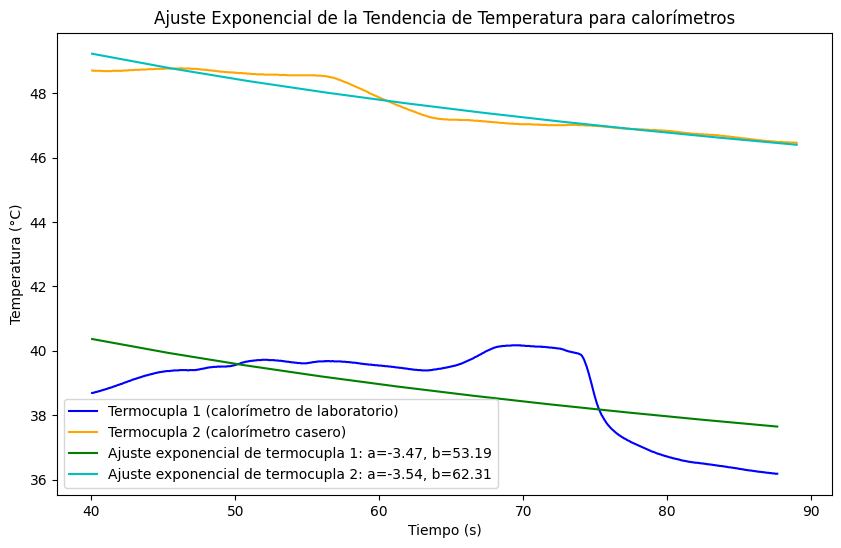

In [217]:
# Ajuste logaritmico de los datos para obtener la ecuación que explica el comportamiento de las mediciones y si están dentro
# de lo esperado en cuanto su tendencia.

# Función logaritmica
def logFit(x, a, b):
    return a * np.log(x) + b

# Ajustar una curva exponencial a los datos

popt_18t1, pcov_18t1 = curve_fit(logFit, d18['Tiempo'].dropna(), d18['Termocupla_1'].dropna())
popt_19t2, pcov_19t2 = curve_fit(logFit, d19['Tiempo'].dropna(), d19['Termocupla_2'].dropna())

# Generar datos para la curva ajustada
tiempo_fit_18t1 = np.linspace(d18['Tiempo'].min(), d18['Tiempo'].max(), 10)
tasa_fit_18t1 = logFit(tiempo_fit_18t1, *popt_18t1)

tiempo_fit_19t2 = np.linspace(d19['Tiempo'].min(), d19['Tiempo'].max(), 10)
tasa_fit_19t2 = logFit(tiempo_fit_19t2, *popt_19t2)

# Calcular R^2 para cada ajuste
R2_18t1 = calcular_R2(d18['Termocupla_1'].dropna(), logFit(d18['Tiempo'].dropna(), *popt_18t1))
R2_19t2 = calcular_R2(d19['Termocupla_2'].dropna(), logFit(d19['Tiempo'].dropna(), *popt_19t2))

# Graficar los datos y la curva ajustada
plt.figure(figsize=(10, 6))
plt.plot(d18['Tiempo'], d18['Termocupla_1'], 'b-', label='Termocupla 1 (calorímetro de laboratorio)')
plt.plot(d19['Tiempo'], d19['Termocupla_2'], 'orange', label='Termocupla 2 (calorímetro casero)')

plt.plot(tiempo_fit_18t1, tasa_fit_18t1, 'g-', label='Ajuste exponencial de termocupla 1: a=%.2f, b=%.2f' % tuple(popt_18t1))
plt.plot(tiempo_fit_19t2, tasa_fit_19t2, 'c-', label='Ajuste exponencial de termocupla 2: a=%.2f, b=%.2f' % tuple(popt_19t2))

plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Ajuste Exponencial de la Tendencia de Temperatura para calorímetros')
plt.legend()


plt.show()

In [218]:
# Recorte de datos para realizar la correlación Pearson
indices_1 = np.where(d19['Tiempo'] == d18['Tiempo'].max())[0][0]+1
d19.drop(d19.index[indices_1:], inplace=True)

In [219]:
corr_coef, p_value = stats.pearsonr(d18['Termocupla_1'].dropna(), d19['Termocupla_2'].dropna())

# Mostrar resultados
print(f"Coeficiente de correlación de Pearson: {corr_coef}")
print(f"Valor p: {p_value}")

# Interpretación del resultado
if p_value < alpha:
    print("Existe una correlación significativa entre los datos.")
else:
    print("No hay suficiente evidencia para afirmar una correlación significativa entre los datos.")

Coeficiente de correlación de Pearson: 0.548272340119642
Valor p: 6.901856596205274e-76
Existe una correlación significativa entre los datos.


**Cálculo del calor absorvido del agua con los bloques de metal, entre calorímetros**

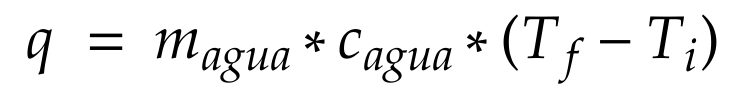

In [220]:
print("Calor absorvido por calorímetros: ")

# Para calorimetro de laboratorio
m = 109.5 #g // masa de la muestra
c = 4.18 #J/g*ºC // calor específico del agua
q_cl = round(m*c*(d18['Termocupla_1'].max()-d18['Termocupla_1'].min()),2)
print('Calorímetro de laboratorio (termocupla 1):', q_cl,'J')

# Para calorimeto casero
q_cs = round(m*c*(d19['Termocupla_2'].max()-d19['Termocupla_2'].min()),2)
print('Calorímetro casero (termocupla 2):', q_cs,'J')

Calor absorvido por calorímetros: 
Calorímetro de laboratorio (termocupla 1): 1826.26 J
Calorímetro casero (termocupla 2): 1048.16 J
